In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

icustay_id  hadm_id  subject_id                 age gender  height  \
0      200001   152234       55973 22290 days 19:06:12      F  170.18   
1      200003   163557       27513 17625 days 19:50:04      M     NaN   
2      200006   189514       10950 19736 days 11:28:14      M     NaN   
3      200007   129310       20707 15818 days 10:03:37      M  177.80   
4      200009   129607       29904 17353 days 10:34:32      F  160.02   

       weight        bmi             ethnicity insurance     ...      \
0   27.669135   9.553853  ASIAN - ASIAN INDIAN  Medicare     ...       
1   78.224998        NaN                 WHITE   Private     ...       
2   82.400002        NaN                 OTHER  Medicaid     ...       
3  126.000000  39.857223                 WHITE   Private     ...       
4   85.833331  33.520264                 WHITE   Private     ...       

   ea_tv_pulm_htn  ea_tv_tr  ea_lv_cavity  ea_lv_diastolic  ea_lv_systolic  \
0             NaN       NaN           NaN              NaN             NaN   
1             1.0       0.0           0.0              0.0             2.0   
2             NaN       NaN           NaN              NaN             NaN   
3             NaN       NaN           NaN              NaN             NaN   
4             NaN       0.0           NaN              NaN             0.0   

   ea_lv_wall  ea_rv_cavity  ea_rv_diastolic_fluid  ea_rv_systolic  ea_rv_wall  
0         NaN           NaN                    NaN             NaN         NaN  
1         0.0           0.0                    NaN             0.0         NaN  
2         NaN           NaN                    NaN             NaN         NaN  
3         NaN           NaN                    NaN             NaN         NaN  
4         NaN           0.0                    NaN             0.0         NaN  

[5 rows x 115 columns]

In [6]:
len(ef)

61532

In [7]:
## apply filters
F = (ef['filter_vaso'] | ef['filter_angus_sepsis']) \
        & ~ef['filter_hard_cardiogenic'] \
        & ~ef['filter_chronic_dialysis'] \
        & ef['filter_adult'] \
        & (ef.st_micu | ef.st_sicu | ef.st_nsicu)

In [8]:
ef = ef.loc[F]
len(ef)

13443

## Calculate MDRD and add to features table

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    3793
1    2997
2    2061
3    1820
4    1725
5     657
dtype: int64

In [11]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    6790
1    3881
2    2382
dtype: int64

## Create general features table

In [12]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [13]:
## is apache score everr missing?
sum(np.isnan(ef.apsiii))

0

In [35]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = np.isnan(lvsys).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## hierarchical terms specific to each lv category
lvs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
columns = X.loc[:,~X.columns.isin(lvs)]
dfs = [X]
for lv in lvs:
    lv_colnames = [lv+'_'+name for name in columns.columns]
    C = (columns.T*X[lv]).T
    C.columns = lv_colnames
    dfs.append(C)

X = pd.concat(dfs, axis=1)

X.head()

age  age_over_90  gender       bmi  bmi_missing  mech_vent  CHF  \
1   0.086189          0.0     0.0  0.000000          1.0        1.0  0.0   
16  0.451056          0.0     1.0  0.000000          1.0        1.0  1.0   
20  0.153221          0.0     0.0  0.003012          0.0        0.0  0.0   
22  0.300244          0.0     0.0 -0.050124          0.0        0.0  0.0   
23  0.151474          0.0     1.0  0.000000          1.0        1.0  0.0   

        mdrd  creatinine_missing    apsiii            ...              \
1   0.401448                 0.0 -0.180877            ...               
16  0.000000                 1.0  0.400357            ...               
20  0.369755                 0.0  0.176806            ...               
22  0.692746                 0.0 -1.030372            ...               
23  0.815494                 0.0 -0.493849            ...               

    lv_severe_gender  lv_severe_bmi  lv_severe_bmi_missing  \
1                0.0            0.0                    0.0   
16               0.0            0.0                    0.0   
20               0.0            0.0                    0.0   
22               0.0           -0.0                    0.0   
23               0.0            0.0                    0.0   

    lv_severe_mech_vent  lv_severe_CHF  lv_severe_mdrd  \
1                   0.0            0.0             0.0   
16                  0.0            0.0             0.0   
20                  0.0            0.0             0.0   
22                  0.0            0.0             0.0   
23                  0.0            0.0             0.0   

    lv_severe_creatinine_missing  lv_severe_apsiii  lv_severe_lactate  \
1                            0.0              -0.0                0.0   
16                           0.0               0.0                0.0   
20                           0.0               0.0                0.0   
22                           0.0              -0.0                0.0   
23                           0.0              -0.0                0.0   

    lv_severe_lactate_missing  
1                         0.0  
16                        0.0  
20                        0.0  
22                        0.0  
23                        0.0  

[5 rows x 90 columns]

## Some helper model building functions

In [36]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [73]:
def lasso(X, y, l=1.0/np.sqrt(2)):
    n = X.shape[1]
    beta = pm.Laplace('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [37]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

## Hierarchical linear model for predicting fluid balance on day 1

In [38]:
## predictive model of fluids given
y_fluid = ef.fb_day1_balance_ml
missing = np.isnan(y_fluid)
np.sum(missing)

1011

In [39]:
# truncate at -8, +8 by changing people out of that range to NaN, cause wow
missing |= (ef.fb_day1_balance_ml < -8000) | (ef.fb_day1_balance_ml > 8000)
sum(missing)

1500

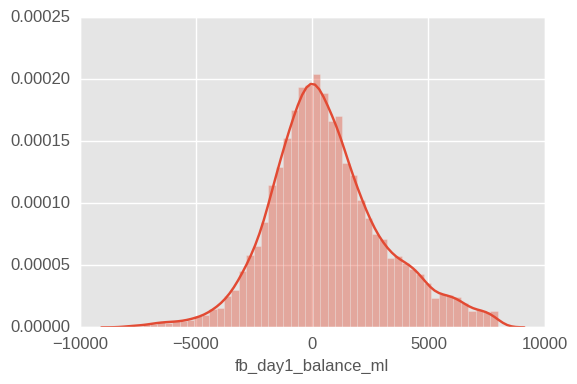

In [40]:
sns.distplot(ef.fb_day1_balance_ml[~missing])

In [41]:
X_fluid = X.loc[~missing]
y_fluid = normalize(y_fluid[~missing])
len(y_fluid)

11943

In [42]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    ridge(X_fluid, y_fluid)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

         Current function value: 16010.136831
         Iterations: 94
         Function evaluations: 183
         Gradient evaluations: 172


100%|██████████| 2000/2000 [40:24<00:00,  1.90it/s]


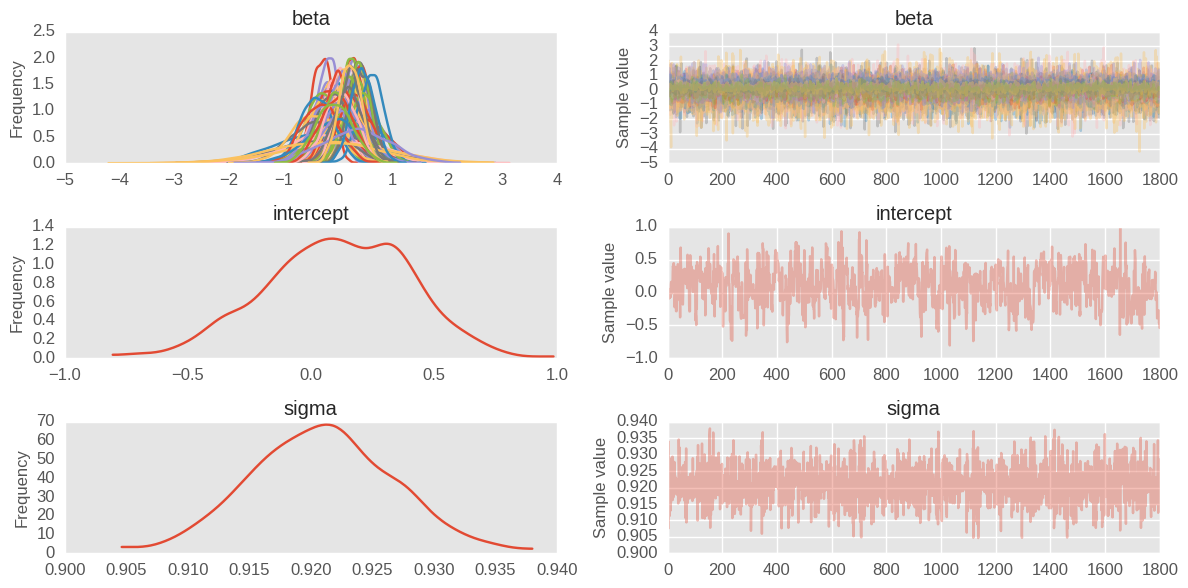

In [43]:
_ = pm.traceplot(trace[200:])

In [44]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_fluid.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

age  age_over_90    gender       bmi  bmi_missing  mech_vent  \
0 -0.321011     0.276414  0.262789 -0.384166    -0.199833   0.018889   
1  0.454373     0.046457 -0.084332 -0.604460    -0.096065   0.027459   
2  0.454373     0.046457 -0.084332 -0.604460    -0.096065   0.027459   
3  0.029972    -0.356980 -0.015059 -0.729795    -0.093430  -0.003190   
4  0.098207    -0.278261  0.005762 -0.728264    -0.104786  -0.023240   

        CHF      mdrd  creatinine_missing    apsiii    ...      lv_severe_bmi  \
0  0.250883 -0.356407           -0.217678  0.359613    ...           0.079491   
1  0.280602 -0.117385           -0.201283  0.273840    ...          -0.232156   
2  0.280602 -0.117385           -0.201283  0.273840    ...          -0.232156   
3  0.124897 -0.026112           -0.262250  0.317114    ...          -0.457146   
4  0.163588 -0.034051           -0.218682  0.302924    ...          -0.406574   

   lv_severe_bmi_missing  lv_severe_mech_vent  lv_severe_CHF  lv_severe_mdrd  \
0               0.172719             0.169493      -0.534140        0.608398   
1              -0.088855             0.320042      -0.347505        0.186836   
2              -0.088855             0.320042      -0.347505        0.186836   
3              -0.010043             0.150206      -0.243996        0.154950   
4              -0.080087             0.011993      -0.382244        0.064973   

   lv_severe_creatinine_missing  lv_severe_apsiii  lv_severe_lactate  \
0                     -0.105560          0.152782           0.109784   
1                     -0.084462          0.115625          -0.073432   
2                     -0.084462          0.115625          -0.073432   
3                      0.873588          0.018288           0.100146   
4                     -0.612242          0.054728           0.181790   

   lv_severe_lactate_missing  intercept  
0                   0.038064  -0.060983  
1                  -0.160315  -0.056983  
2                  -0.160315  -0.056983  
3                  -0.099783   0.021923  
4                  -0.080223   0.006486  

[5 rows x 91 columns]

In [45]:
sample_coefs.describe()

age  age_over_90       gender          bmi  bmi_missing  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean      0.232985     0.198139    -0.216261    -0.150231    -0.172212   
std       0.358057     0.349423     0.265927     0.472204     0.261772   
min      -1.065285    -0.980590    -0.987917    -1.693676    -1.174381   
25%       0.001816    -0.040403    -0.402592    -0.470409    -0.352933   
50%       0.226318     0.199914    -0.214463    -0.147676    -0.161158   
75%       0.469537     0.416907    -0.043543     0.144332    -0.000706   
max       1.303917     1.460407     0.721239     1.565286     0.661753   

         mech_vent          CHF         mdrd  creatinine_missing       apsiii  \
count  1800.000000  1800.000000  1800.000000         1800.000000  1800.000000   
mean      0.205471    -0.139200    -0.294554           -0.107548     0.234101   
std       0.265997     0.280625     0.187963            0.418662     0.214552   
min      -0.929897    -1.086390    -0.855213           -1.485507    -0.529705   
25%       0.024038    -0.327348    -0.426881           -0.384886     0.084303   
50%       0.205183    -0.141433    -0.292551           -0.106303     0.232043   
75%       0.389905     0.048331    -0.166308            0.183447     0.384984   
max       1.015795     0.751384     0.348881            1.244440     0.896593   

          ...       lv_severe_bmi  lv_severe_bmi_missing  lv_severe_mech_vent  \
count     ...         1800.000000            1800.000000          1800.000000   
mean      ...           -0.289408              -0.000786             0.044137   
std       ...            0.976180               0.290793             0.289378   
min       ...           -4.199940              -1.051536            -1.096182   
25%       ...           -0.946230              -0.197955            -0.153872   
50%       ...           -0.266653              -0.003518             0.053766   
75%       ...            0.369541               0.200297             0.244916   
max       ...            2.750649               0.955116             1.190586   

       lv_severe_CHF  lv_severe_mdrd  lv_severe_creatinine_missing  \
count    1800.000000     1800.000000                   1800.000000   
mean       -0.021973        0.452579                      0.329076   
std         0.306832        0.213941                      0.622996   
min        -1.215178       -0.270267                     -1.893411   
25%        -0.231246        0.304074                     -0.080916   
50%        -0.012632        0.445112                      0.346592   
75%         0.183831        0.596989                      0.746497   
max         0.935704        1.233085                      2.227613   

       lv_severe_apsiii  lv_severe_lactate  lv_severe_lactate_missing  \
count       1800.000000        1800.000000                1800.000000   
mean           0.239705           0.216727                  -0.070227   
std            0.227158           0.201993                   0.329886   
min           -0.513381          -0.540721                  -1.154973   
25%            0.083805           0.080680                  -0.298153   
50%            0.236049           0.214809                  -0.075475   
75%            0.395266           0.352675                   0.157420   
max            1.095809           0.898254                   1.065049   

         intercept  
count  1800.000000  
mean      0.103803  
std       0.289368  
min      -0.804720  
25%      -0.089637  
50%       0.111519  
75%       0.315995  
max       0.985881  

[8 rows x 91 columns]

In [46]:
W = sample_coefs.values[:,:X_fluid.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_fluid.values, W.T) + b
y_ppc = y_ppc.T

In [47]:
r2_ppc = np.zeros(len(y_ppc))
for i in range(len(y_ppc)):
    yh = y_ppc[i]
    r = pearsonr(yh, y_fluid)[0]
    r2_ppc[i] = r**2

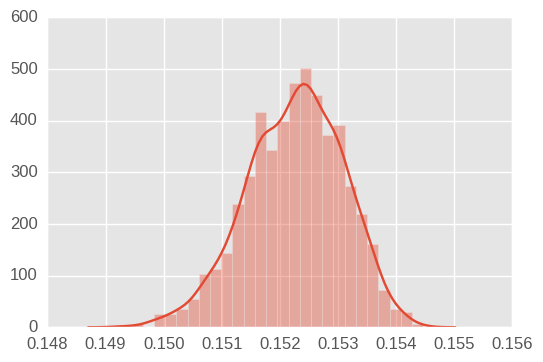

In [48]:
sns.distplot(r2_ppc)

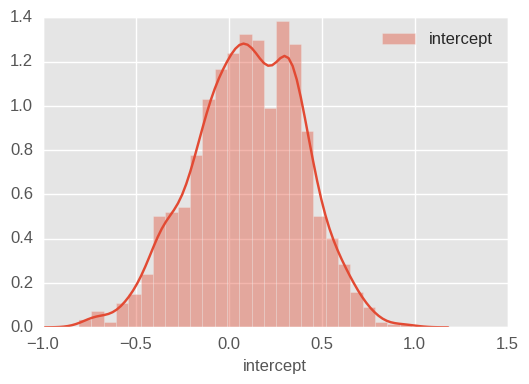

In [49]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

age  age_over_90       gender          bmi  bmi_missing
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000
mean      0.232985     0.198139    -0.216261    -0.150231    -0.172212
std       0.358057     0.349423     0.265927     0.472204     0.261772
min      -1.065285    -0.980590    -0.987917    -1.693676    -1.174381
25%       0.001816    -0.040403    -0.402592    -0.470409    -0.352933
50%       0.226318     0.199914    -0.214463    -0.147676    -0.161158
75%       0.469537     0.416907    -0.043543     0.144332    -0.000706
max       1.303917     1.460407     0.721239     1.565286     0.661753

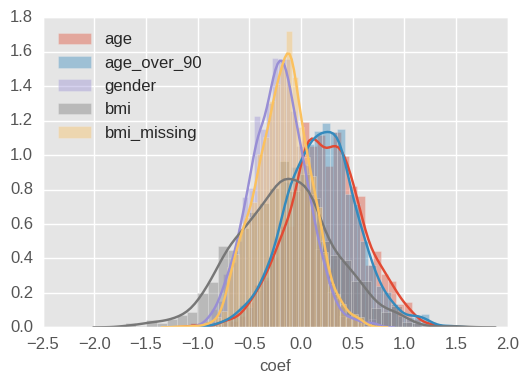

In [50]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

mech_vent          CHF       apsiii         mdrd  creatinine_missing  \
count  1800.000000  1800.000000  1800.000000  1800.000000         1800.000000   
mean      0.205471    -0.139200     0.234101    -0.294554           -0.107548   
std       0.265997     0.280625     0.214552     0.187963            0.418662   
min      -0.929897    -1.086390    -0.529705    -0.855213           -1.485507   
25%       0.024038    -0.327348     0.084303    -0.426881           -0.384886   
50%       0.205183    -0.141433     0.232043    -0.292551           -0.106303   
75%       0.389905     0.048331     0.384984    -0.166308            0.183447   
max       1.015795     0.751384     0.896593     0.348881            1.244440   

           lactate  lactate_missing  
count  1800.000000      1800.000000  
mean     -0.168426        -0.157216  
std       0.189609         0.304788  
min      -0.799406        -1.229098  
25%      -0.300004        -0.353785  
50%      -0.167702        -0.156851  
75%      -0.045010         0.054463  
max       0.595618         0.817917

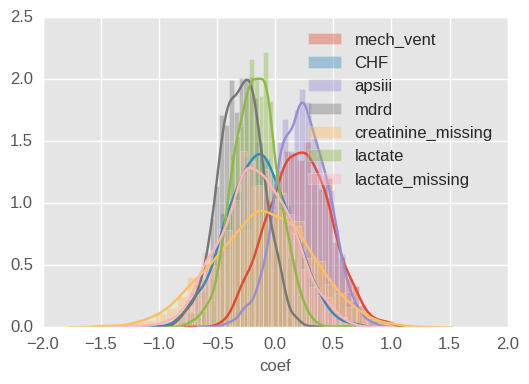

In [51]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_missing    lv_normal     lv_hyper      lv_mild  lv_moderate  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean     -0.067852     0.000687     0.188248     0.011402     0.116262   
std       0.289978     0.291097     0.311653     0.327287     0.348214   
min      -0.897839    -0.923541    -0.754940    -1.009909    -1.020954   
25%      -0.280435    -0.213459    -0.031205    -0.218262    -0.123289   
50%      -0.079086    -0.004352     0.169829     0.000237     0.108160   
75%       0.125462     0.192763     0.395492     0.235800     0.360796   
max       0.857320     0.942318     1.199830     1.127207     1.241085   

         lv_severe  
count  1800.000000  
mean     -0.117519  
std       0.339515  
min      -1.305176  
25%      -0.366397  
50%      -0.121712  
75%       0.112728  
max       1.001246

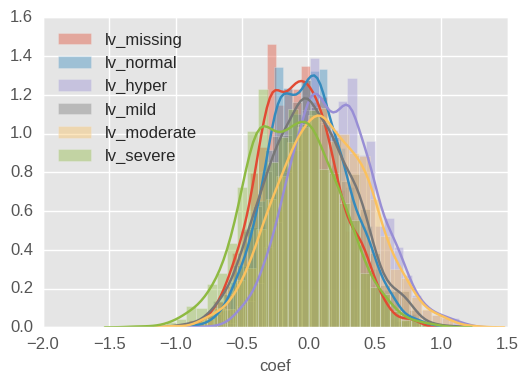

In [52]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

bmi  lv_missing_bmi  lv_normal_bmi  lv_hyper_bmi  lv_mild_bmi  \
count  1800.000000     1800.000000    1800.000000   1800.000000  1800.000000   
mean     -0.150231        0.111893       0.095312     -0.179827     0.152115   
std       0.472204        0.471959       0.482464      0.921022     0.472290   
min      -1.693676       -1.612637      -1.546190     -2.964039    -1.564116   
25%      -0.470409       -0.182281      -0.217231     -0.819894    -0.142769   
50%      -0.147676        0.099281       0.093483     -0.204317     0.150715   
75%       0.144332        0.429855       0.419443      0.450589     0.471277   
max       1.565286        1.657302       1.695491      2.879959     1.700831   

       lv_moderate_bmi  lv_severe_bmi  
count      1800.000000    1800.000000  
mean         -0.018683      -0.289408  
std           0.955964       0.976180  
min          -3.167138      -4.199940  
25%          -0.675164      -0.946230  
50%          -0.012049      -0.266653  
75%           0.651753       0.369541  
max           3.130297       2.750649

bmi_missing  lv_missing_bmi_missing  lv_normal_bmi_missing  \
count  1800.000000             1800.000000            1800.000000   
mean     -0.172212                0.031927              -0.071781   
std       0.261772                0.262194               0.263898   
min      -1.174381               -0.826596              -0.965601   
25%      -0.352933               -0.145473              -0.243128   
50%      -0.161158                0.018217              -0.083975   
75%      -0.000706                0.210342               0.103051   
max       0.661753                1.010564               0.933289   

       lv_hyper_bmi_missing  lv_mild_bmi_missing  lv_moderate_bmi_missing  \
count           1800.000000          1800.000000              1800.000000   
mean               0.094895             0.047499                 0.311095   
std                0.279921             0.281949                 0.297193   
min               -0.765223            -0.840439                -0.594557   
25%               -0.093634            -0.137451                 0.112979   
50%                0.085753             0.044744                 0.307602   
75%                0.284139             0.224201                 0.505798   
max                1.038289             1.122795                 1.420151   

       lv_severe_bmi_missing  
count            1800.000000  
mean               -0.000786  
std                 0.290793  
min                -1.051536  
25%                -0.197955  
50%                -0.003518  
75%                 0.200297  
max                 0.955116

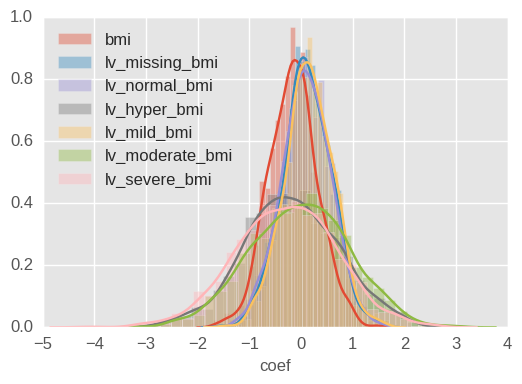

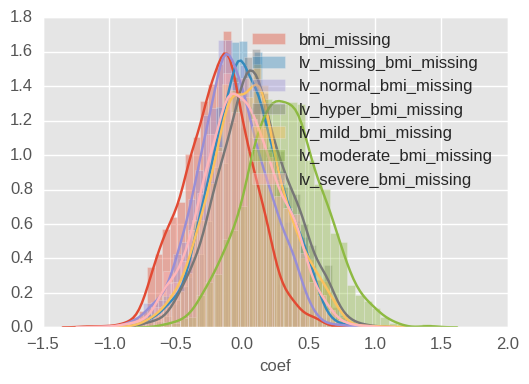

In [64]:
suffix = 'bmi'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

suffix = 'bmi_missing'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

age  lv_missing_age  lv_normal_age  lv_hyper_age  lv_mild_age  \
count  1800.000000     1800.000000    1800.000000   1800.000000  1800.000000   
mean      0.232985        0.279602       0.447183      0.438416     0.000712   
std       0.358057        0.363582       0.370662      0.451423     0.455984   
min      -1.065285       -0.890604      -0.607010     -0.925812    -1.511498   
25%       0.001816        0.037698       0.202211      0.118943    -0.310281   
50%       0.226318        0.281474       0.447926      0.434122    -0.004258   
75%       0.469537        0.516376       0.688966      0.741571     0.311927   
max       1.303917        1.554982       1.750462      1.821096     1.649479   

       lv_moderate_age  lv_severe_age  
count      1800.000000    1800.000000  
mean         -0.368574      -0.073594  
std           0.500052       0.487856  
min          -2.023440      -1.479680  
25%          -0.715628      -0.397703  
50%          -0.372942      -0.061251  
75%          -0.022988       0.229384  
max           1.205696       1.597059

age_over_90  lv_missing_age_over_90  lv_normal_age_over_90  \
count  1800.000000             1800.000000            1800.000000   
mean      0.198139                0.082447               0.136617   
std       0.349423                0.350313               0.354347   
min      -0.980590               -1.111049              -1.171803   
25%      -0.040403               -0.144786              -0.084186   
50%       0.199914                0.085823               0.139150   
75%       0.416907                0.313503               0.364662   
max       1.460407                1.254072               1.290617   

       lv_hyper_age_over_90  lv_mild_age_over_90  lv_moderate_age_over_90  \
count           1800.000000          1800.000000              1800.000000   
mean               0.384811             0.093605                -0.449267   
std                0.398088             0.400305                 0.419242   
min               -0.982415            -1.528129                -1.995791   
25%                0.130765            -0.150618                -0.728395   
50%                0.383188             0.088144                -0.453147   
75%                0.640598             0.346734                -0.179193   
max                1.587073             1.600598                 1.157501   

       lv_severe_age_over_90  
count            1800.000000  
mean                0.105710  
std                 0.403366  
min                -1.200979  
25%                -0.154285  
50%                 0.110127  
75%                 0.373936  
max                 1.507617

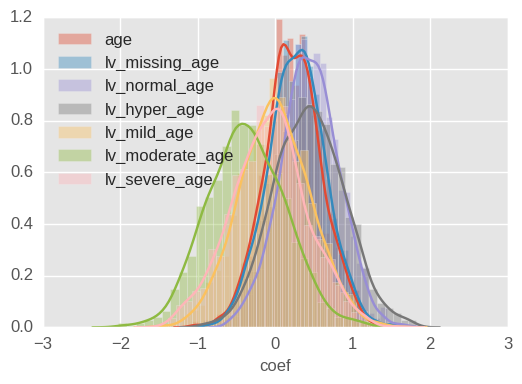

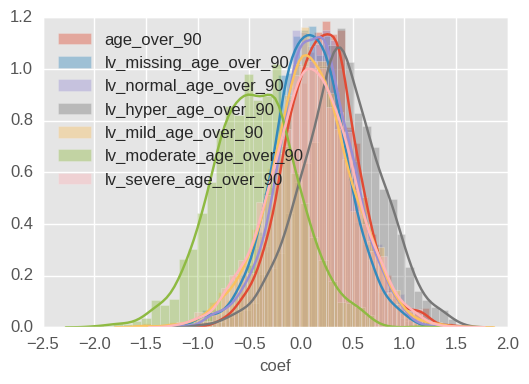

In [66]:
suffix = 'age'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

suffix = 'age_over_90'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

gender  lv_missing_gender  lv_normal_gender  lv_hyper_gender  \
count  1800.000000        1800.000000       1800.000000      1800.000000   
mean     -0.216261           0.265057          0.267026         0.196379   
std       0.265927           0.267088          0.268178         0.286095   
min      -0.987917          -0.700870         -0.720867        -0.806580   
25%      -0.402592           0.088797          0.092464         0.006042   
50%      -0.214463           0.263469          0.265589         0.195339   
75%      -0.043543           0.449449          0.449186         0.386613   
max       0.721239           1.040313          1.027864         1.124930   

       lv_mild_gender  lv_moderate_gender  lv_severe_gender  
count     1800.000000         1800.000000       1800.000000  
mean         0.142515            0.431588          0.194115  
std          0.285378            0.301114          0.288530  
min         -1.004300           -0.586526         -0.877617  
25%         -0.049060            0.228193          0.008241  
50%          0.143454            0.444340          0.192339  
75%          0.338198            0.636064          0.383845  
max          1.170626            1.271914          1.018954

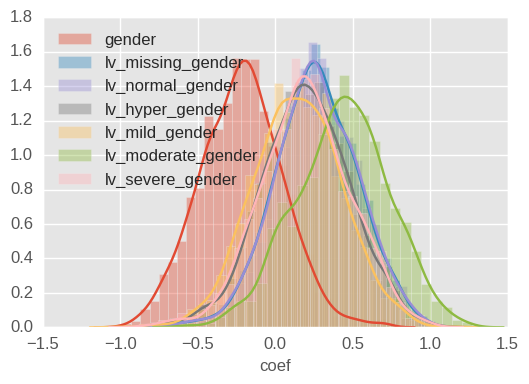

In [67]:
suffix = 'gender'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

apsiii  lv_missing_apsiii  lv_normal_apsiii  lv_hyper_apsiii  \
count  1800.000000        1800.000000       1800.000000      1800.000000   
mean      0.234101           0.035392          0.081429         0.082529   
std       0.214552           0.214571          0.215114         0.219668   
min      -0.529705          -0.615653         -0.552555        -0.665309   
25%       0.084303          -0.108266         -0.066117        -0.071101   
50%       0.232043           0.036523          0.083139         0.082692   
75%       0.384984           0.184542          0.225735         0.232085   
max       0.896593           0.813833          0.834971         0.887163   

       lv_mild_apsiii  lv_moderate_apsiii  lv_severe_apsiii  
count     1800.000000         1800.000000       1800.000000  
mean         0.009479            0.203073          0.239705  
std          0.225917            0.234948          0.227158  
min         -0.699583           -0.491723         -0.513381  
25%         -0.149564            0.040117          0.083805  
50%          0.003589            0.200218          0.236049  
75%          0.164315            0.361597          0.395266  
max          0.803839            0.963458          1.095809

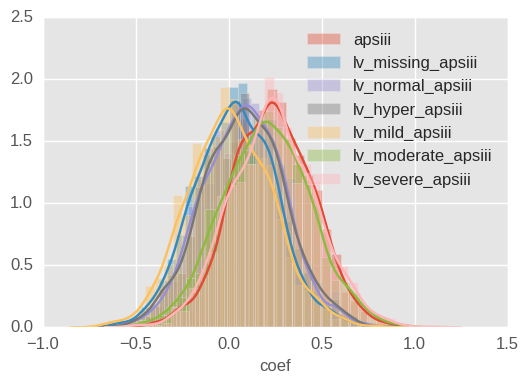

In [68]:
suffix = 'apsiii'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

CHF  lv_missing_CHF  lv_normal_CHF  lv_hyper_CHF  lv_mild_CHF  \
count  1800.000000     1800.000000    1800.000000   1800.000000  1800.000000   
mean     -0.139200       -0.044098      -0.092881     -0.077241     0.150586   
std       0.280625        0.281950       0.285978      0.297169     0.300097   
min      -1.086390       -0.936504      -1.005739     -1.118590    -0.798837   
25%      -0.327348       -0.234143      -0.290288     -0.276919    -0.053616   
50%      -0.141433       -0.041275      -0.083953     -0.083967     0.152591   
75%       0.048331        0.144858       0.098766      0.133550     0.351765   
max       0.751384        0.924026       0.799477      0.921380     1.157654   

       lv_moderate_CHF  lv_severe_CHF  
count      1800.000000    1800.000000  
mean          0.056955      -0.021973  
std           0.318860       0.306832  
min          -1.012662      -1.215178  
25%          -0.162115      -0.231246  
50%           0.059956      -0.012632  
75%           0.280050       0.183831  
max           1.014517       0.935704

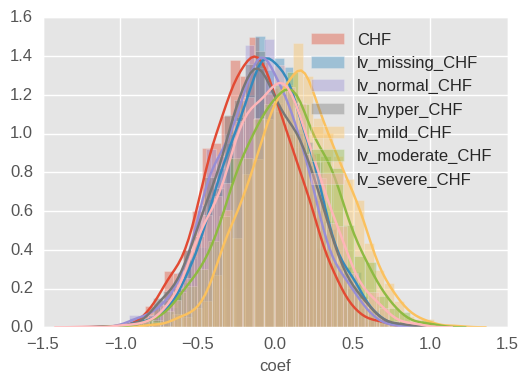

In [69]:
suffix = 'CHF'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

mech_vent  lv_missing_mech_vent  lv_normal_mech_vent  \
count  1800.000000           1800.000000          1800.000000   
mean      0.205471             -0.137512            -0.133361   
std       0.265997              0.267169             0.267665   
min      -0.929897             -0.934030            -0.956463   
25%       0.024038             -0.322497            -0.313430   
50%       0.205183             -0.142490            -0.130814   
75%       0.389905              0.049711             0.052410   
max       1.015795              0.980587             1.047344   

       lv_hyper_mech_vent  lv_mild_mech_vent  lv_moderate_mech_vent  \
count         1800.000000        1800.000000            1800.000000   
mean            -0.296985          -0.117830              -0.392295   
std              0.286212           0.285833               0.308456   
min             -1.359219          -1.189779              -1.406729   
25%             -0.491172          -0.310086              -0.601904   
50%             -0.293369          -0.116721              -0.398773   
75%             -0.102094           0.072838              -0.191487   
max              0.901310           1.072145               0.633924   

       lv_severe_mech_vent  
count          1800.000000  
mean              0.044137  
std               0.289378  
min              -1.096182  
25%              -0.153872  
50%               0.053766  
75%               0.244916  
max               1.190586

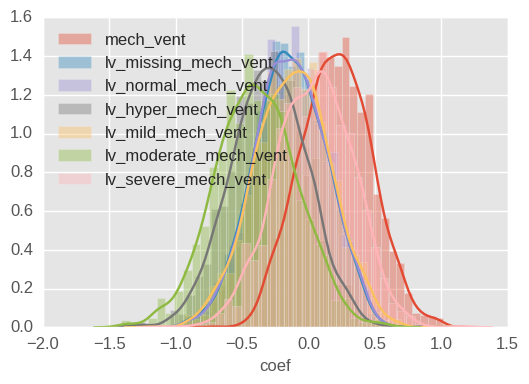

In [70]:
suffix = 'mech_vent'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

gender  lv_missing_gender  lv_normal_gender  lv_hyper_gender  \
count  1800.000000        1800.000000       1800.000000      1800.000000   
mean     -0.216261           0.265057          0.267026         0.196379   
std       0.265927           0.267088          0.268178         0.286095   
min      -0.987917          -0.700870         -0.720867        -0.806580   
25%      -0.402592           0.088797          0.092464         0.006042   
50%      -0.214463           0.263469          0.265589         0.195339   
75%      -0.043543           0.449449          0.449186         0.386613   
max       0.721239           1.040313          1.027864         1.124930   

       lv_mild_gender  lv_moderate_gender  lv_severe_gender  
count     1800.000000         1800.000000       1800.000000  
mean         0.142515            0.431588          0.194115  
std          0.285378            0.301114          0.288530  
min         -1.004300           -0.586526         -0.877617  
25%         -0.049060            0.228193          0.008241  
50%          0.143454            0.444340          0.192339  
75%          0.338198            0.636064          0.383845  
max          1.170626            1.271914          1.018954

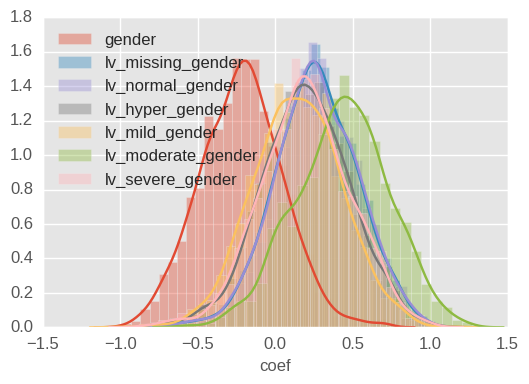

In [67]:
suffix = 'gender'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_missing_age  lv_missing_age_over_90  lv_missing_gender  \
count     1800.000000             1800.000000        1800.000000   
mean         0.279602                0.082447           0.265057   
std          0.363582                0.350313           0.267088   
min         -0.890604               -1.111049          -0.700870   
25%          0.037698               -0.144786           0.088797   
50%          0.281474                0.085823           0.263469   
75%          0.516376                0.313503           0.449449   
max          1.554982                1.254072           1.040313   

       lv_missing_bmi  lv_missing_bmi_missing  
count     1800.000000             1800.000000  
mean         0.111893                0.031927  
std          0.471959                0.262194  
min         -1.612637               -0.826596  
25%         -0.182281               -0.145473  
50%          0.099281                0.018217  
75%          0.429855                0.210342  
max          1.657302                1.010564

lv_missing_mech_vent  lv_missing_CHF  lv_missing_apsiii  \
count           1800.000000     1800.000000        1800.000000   
mean              -0.137512       -0.044098           0.035392   
std                0.267169        0.281950           0.214571   
min               -0.934030       -0.936504          -0.615653   
25%               -0.322497       -0.234143          -0.108266   
50%               -0.142490       -0.041275           0.036523   
75%                0.049711        0.144858           0.184542   
max                0.980587        0.924026           0.813833   

       lv_missing_mdrd  lv_missing_creatinine_missing  lv_missing_lactate  \
count      1800.000000                    1800.000000         1800.000000   
mean          0.302352                       0.109624            0.261927   
std           0.188026                       0.420544            0.190072   
min          -0.346419                      -1.178303           -0.489691   
25%           0.174710                      -0.179911            0.136348   
50%           0.299883                       0.093278            0.264182   
75%           0.434410                       0.394553            0.395100   
max           0.860727                       1.514003            0.889286   

       lv_missing_lactate_missing  
count                 1800.000000  
mean                    -0.110682  
std                      0.305022  
min                     -1.069199  
25%                     -0.326436  
50%                     -0.108716  
75%                      0.088291  
max                      0.949059

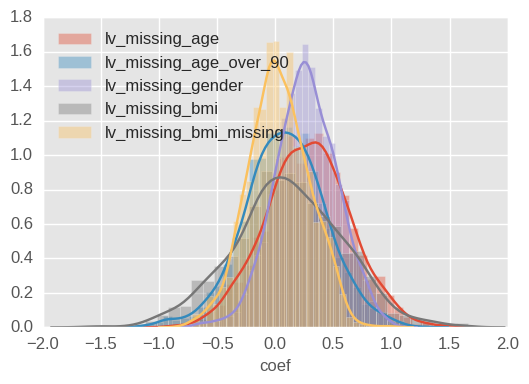

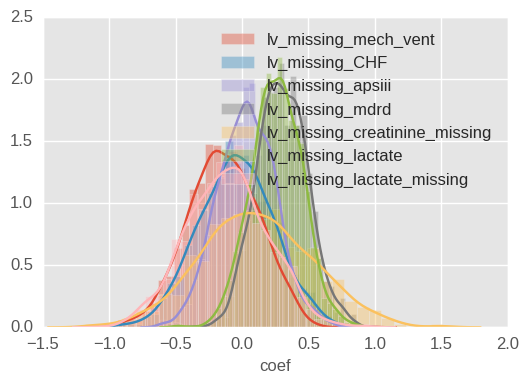

In [55]:
lv = 'lv_missing'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_normal_age  lv_normal_age_over_90  lv_normal_gender  lv_normal_bmi  \
count    1800.000000            1800.000000       1800.000000    1800.000000   
mean        0.447183               0.136617          0.267026       0.095312   
std         0.370662               0.354347          0.268178       0.482464   
min        -0.607010              -1.171803         -0.720867      -1.546190   
25%         0.202211              -0.084186          0.092464      -0.217231   
50%         0.447926               0.139150          0.265589       0.093483   
75%         0.688966               0.364662          0.449186       0.419443   
max         1.750462               1.290617          1.027864       1.695491   

       lv_normal_bmi_missing  
count            1800.000000  
mean               -0.071781  
std                 0.263898  
min                -0.965601  
25%                -0.243128  
50%                -0.083975  
75%                 0.103051  
max                 0.933289

lv_normal_mech_vent  lv_normal_CHF  lv_normal_apsiii  lv_normal_mdrd  \
count          1800.000000    1800.000000       1800.000000     1800.000000   
mean             -0.133361      -0.092881          0.081429        0.341686   
std               0.267665       0.285978          0.215114        0.188846   
min              -0.956463      -1.005739         -0.552555       -0.312942   
25%              -0.313430      -0.290288         -0.066117        0.210876   
50%              -0.130814      -0.083953          0.083139        0.333133   
75%               0.052410       0.098766          0.225735        0.473244   
max               1.047344       0.799477          0.834971        0.916832   

       lv_normal_creatinine_missing  lv_normal_lactate  \
count                   1800.000000        1800.000000   
mean                      -0.112198           0.253794   
std                        0.432985           0.191185   
min                       -1.539070          -0.515208   
25%                       -0.411383           0.127272   
50%                       -0.116967           0.252575   
75%                        0.169983           0.388733   
max                        1.262304           0.915018   

       lv_normal_lactate_missing  
count                1800.000000  
mean                   -0.180387  
std                     0.306955  
min                    -1.111249  
25%                    -0.394894  
50%                    -0.182269  
75%                     0.025951  
max                     0.927842

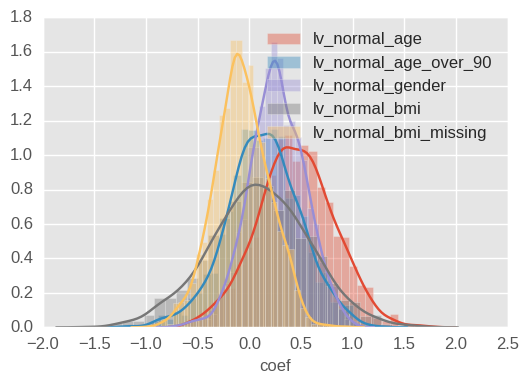

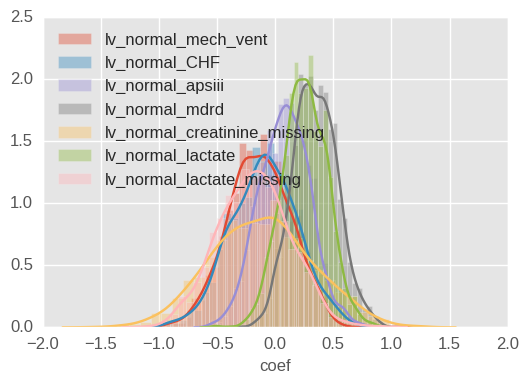

In [56]:
lv = 'lv_normal'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_hyper_age  lv_hyper_age_over_90  lv_hyper_gender  lv_hyper_bmi  \
count   1800.000000           1800.000000      1800.000000   1800.000000   
mean       0.438416              0.384811         0.196379     -0.179827   
std        0.451423              0.398088         0.286095      0.921022   
min       -0.925812             -0.982415        -0.806580     -2.964039   
25%        0.118943              0.130765         0.006042     -0.819894   
50%        0.434122              0.383188         0.195339     -0.204317   
75%        0.741571              0.640598         0.386613      0.450589   
max        1.821096              1.587073         1.124930      2.879959   

       lv_hyper_bmi_missing  
count           1800.000000  
mean               0.094895  
std                0.279921  
min               -0.765223  
25%               -0.093634  
50%                0.085753  
75%                0.284139  
max                1.038289

lv_hyper_mech_vent  lv_hyper_CHF  lv_hyper_apsiii  lv_hyper_mdrd  \
count         1800.000000   1800.000000      1800.000000    1800.000000   
mean            -0.296985     -0.077241         0.082529       0.402256   
std              0.286212      0.297169         0.219668       0.203465   
min             -1.359219     -1.118590        -0.665309      -0.272755   
25%             -0.491172     -0.276919        -0.071101       0.263508   
50%             -0.293369     -0.083967         0.082692       0.403554   
75%             -0.102094      0.133550         0.232085       0.542810   
max              0.901310      0.921380         0.887163       1.016389   

       lv_hyper_creatinine_missing  lv_hyper_lactate  lv_hyper_lactate_missing  
count                  1800.000000       1800.000000               1800.000000  
mean                     -0.471761          0.376024                 -0.269073  
std                       0.710787          0.202493                  0.321831  
min                      -2.781486         -0.472936                 -1.266134  
25%                      -0.952434          0.240585                 -0.497326  
50%                      -0.479634          0.376182                 -0.268388  
75%                       0.015357          0.509285                 -0.048547  
max                       1.756247          1.073293                  0.894099

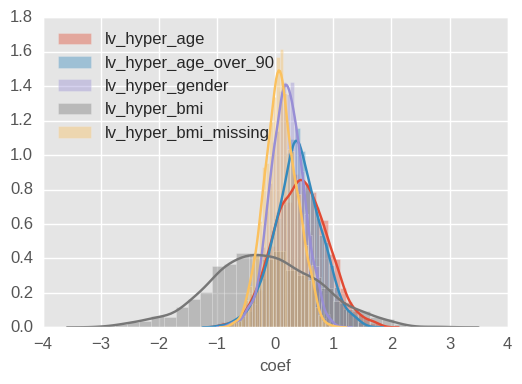

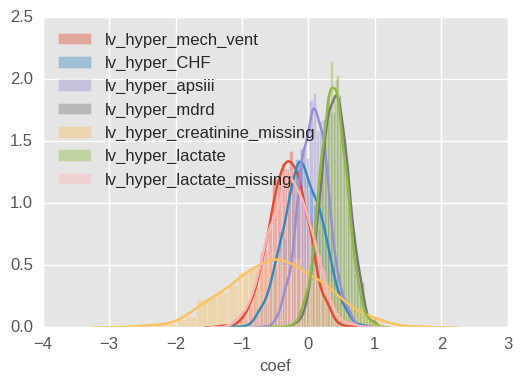

In [57]:
lv = 'lv_hyper'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_mild_age  lv_mild_age_over_90  lv_mild_gender  lv_mild_bmi  \
count  1800.000000          1800.000000     1800.000000  1800.000000   
mean      0.000712             0.093605        0.142515     0.152115   
std       0.455984             0.400305        0.285378     0.472290   
min      -1.511498            -1.528129       -1.004300    -1.564116   
25%      -0.310281            -0.150618       -0.049060    -0.142769   
50%      -0.004258             0.088144        0.143454     0.150715   
75%       0.311927             0.346734        0.338198     0.471277   
max       1.649479             1.600598        1.170626     1.700831   

       lv_mild_bmi_missing  
count          1800.000000  
mean              0.047499  
std               0.281949  
min              -0.840439  
25%              -0.137451  
50%               0.044744  
75%               0.224201  
max               1.122795

lv_mild_mech_vent  lv_mild_CHF  lv_mild_apsiii  lv_mild_mdrd  \
count        1800.000000  1800.000000     1800.000000   1800.000000   
mean           -0.117830     0.150586        0.009479      0.377286   
std             0.285833     0.300097        0.225917      0.204800   
min            -1.189779    -0.798837       -0.699583     -0.332722   
25%            -0.310086    -0.053616       -0.149564      0.237430   
50%            -0.116721     0.152591        0.003589      0.375517   
75%             0.072838     0.351765        0.164315      0.514501   
max             1.072145     1.157654        0.803839      1.082079   

       lv_mild_creatinine_missing  lv_mild_lactate  lv_mild_lactate_missing  
count                 1800.000000      1800.000000              1800.000000  
mean                    -0.177356         0.606305                -0.169192  
std                      0.720180         0.226858                 0.326159  
min                     -2.961835        -0.147645                -1.154152  
25%                     -0.654368         0.448890                -0.389278  
50%                     -0.193961         0.604851                -0.167995  
75%                      0.298524         0.759570                 0.052090  
max                      2.127811         1.506600                 1.036014

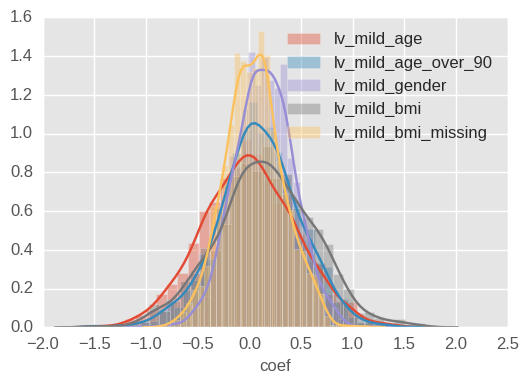

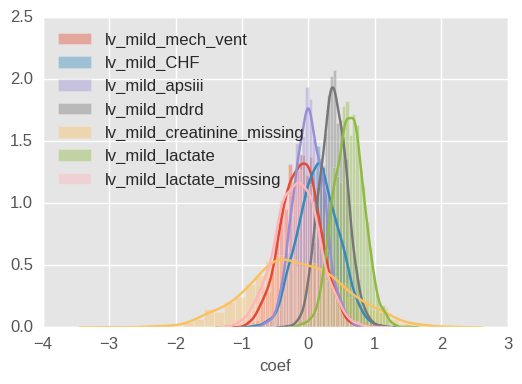

In [58]:
lv = 'lv_mild'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_moderate_age  lv_moderate_age_over_90  lv_moderate_gender  \
count      1800.000000              1800.000000         1800.000000   
mean         -0.368574                -0.449267            0.431588   
std           0.500052                 0.419242            0.301114   
min          -2.023440                -1.995791           -0.586526   
25%          -0.715628                -0.728395            0.228193   
50%          -0.372942                -0.453147            0.444340   
75%          -0.022988                -0.179193            0.636064   
max           1.205696                 1.157501            1.271914   

       lv_moderate_bmi  lv_moderate_bmi_missing  
count      1800.000000              1800.000000  
mean         -0.018683                 0.311095  
std           0.955964                 0.297193  
min          -3.167138                -0.594557  
25%          -0.675164                 0.112979  
50%          -0.012049                 0.307602  
75%           0.651753                 0.505798  
max           3.130297                 1.420151

lv_moderate_mech_vent  lv_moderate_CHF  lv_moderate_apsiii  \
count            1800.000000      1800.000000         1800.000000   
mean               -0.392295         0.056955            0.203073   
std                 0.308456         0.318860            0.234948   
min                -1.406729        -1.012662           -0.491723   
25%                -0.601904        -0.162115            0.040117   
50%                -0.398773         0.059956            0.200218   
75%                -0.191487         0.280050            0.361597   
max                 0.633924         1.014517            0.963458   

       lv_moderate_mdrd  lv_moderate_creatinine_missing  lv_moderate_lactate  \
count       1800.000000                     1800.000000          1800.000000   
mean           0.413284                       -0.037275             0.189780   
std            0.213217                        0.999373             0.212593   
min           -0.306619                       -3.435293            -0.640135   
25%            0.267883                       -0.692804             0.052746   
50%            0.409456                       -0.050388             0.193932   
75%            0.561302                        0.639480             0.331588   
max            1.143751                        2.836676             0.936545   

       lv_moderate_lactate_missing  
count                  1800.000000  
mean                     -0.322332  
std                       0.334366  
min                      -1.331262  
25%                      -0.556665  
50%                      -0.322146  
75%                      -0.102272  
max                       0.788262

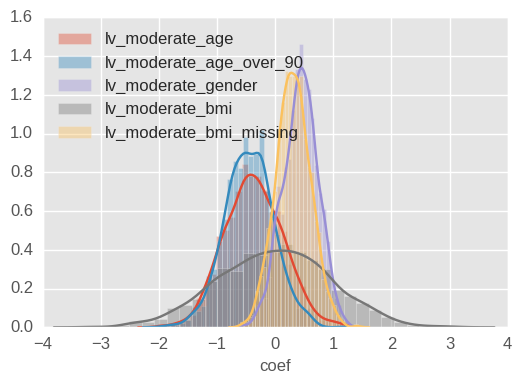

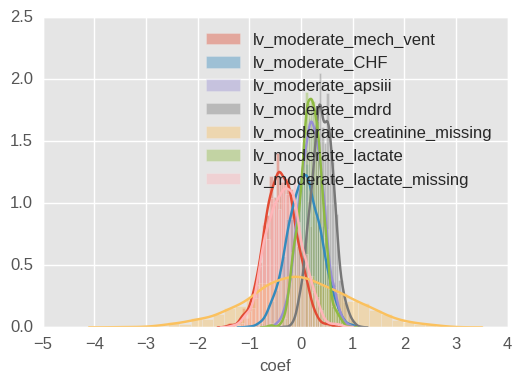

In [59]:
lv = 'lv_moderate'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_severe_age  lv_severe_age_over_90  lv_severe_gender  lv_severe_bmi  \
count    1800.000000            1800.000000       1800.000000    1800.000000   
mean       -0.073594               0.105710          0.194115      -0.289408   
std         0.487856               0.403366          0.288530       0.976180   
min        -1.479680              -1.200979         -0.877617      -4.199940   
25%        -0.397703              -0.154285          0.008241      -0.946230   
50%        -0.061251               0.110127          0.192339      -0.266653   
75%         0.229384               0.373936          0.383845       0.369541   
max         1.597059               1.507617          1.018954       2.750649   

       lv_severe_bmi_missing  
count            1800.000000  
mean               -0.000786  
std                 0.290793  
min                -1.051536  
25%                -0.197955  
50%                -0.003518  
75%                 0.200297  
max                 0.955116

lv_severe_mech_vent  lv_severe_CHF  lv_severe_apsiii  lv_severe_mdrd  \
count          1800.000000    1800.000000       1800.000000     1800.000000   
mean              0.044137      -0.021973          0.239705        0.452579   
std               0.289378       0.306832          0.227158        0.213941   
min              -1.096182      -1.215178         -0.513381       -0.270267   
25%              -0.153872      -0.231246          0.083805        0.304074   
50%               0.053766      -0.012632          0.236049        0.445112   
75%               0.244916       0.183831          0.395266        0.596989   
max               1.190586       0.935704          1.095809        1.233085   

       lv_severe_creatinine_missing  lv_severe_lactate  \
count                   1800.000000        1800.000000   
mean                       0.329076           0.216727   
std                        0.622996           0.201993   
min                       -1.893411          -0.540721   
25%                       -0.080916           0.080680   
50%                        0.346592           0.214809   
75%                        0.746497           0.352675   
max                        2.227613           0.898254   

       lv_severe_lactate_missing  
count                1800.000000  
mean                   -0.070227  
std                     0.329886  
min                    -1.154973  
25%                    -0.298153  
50%                    -0.075475  
75%                     0.157420  
max                     1.065049

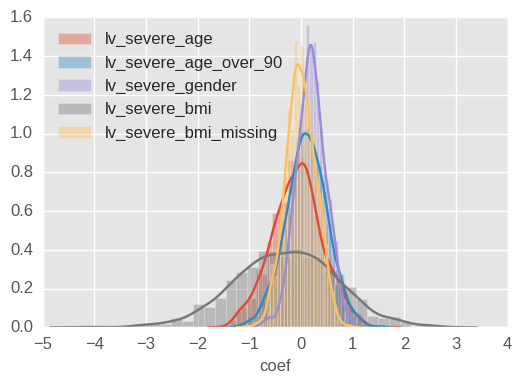

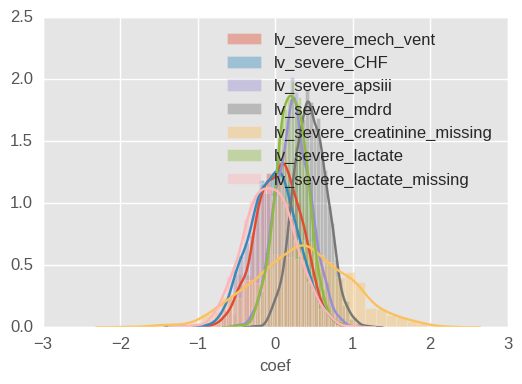

In [60]:
lv = 'lv_severe'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

## Hierarchical linear model for predicting fluid balance on day 1, Laplace prior

In [76]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    lasso(X_fluid, y_fluid)
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace = pm.sample(2000, step)
    trace = pm.sample(2000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -16,160: 100%|██████████| 200000/200000 [03:01<00:00, 1104.53it/s]
INFO:pymc3:Finished [100%]: Average ELBO = -16,160
100%|██████████| 2000/2000 [1:19:45<00:00,  1.04it/s]


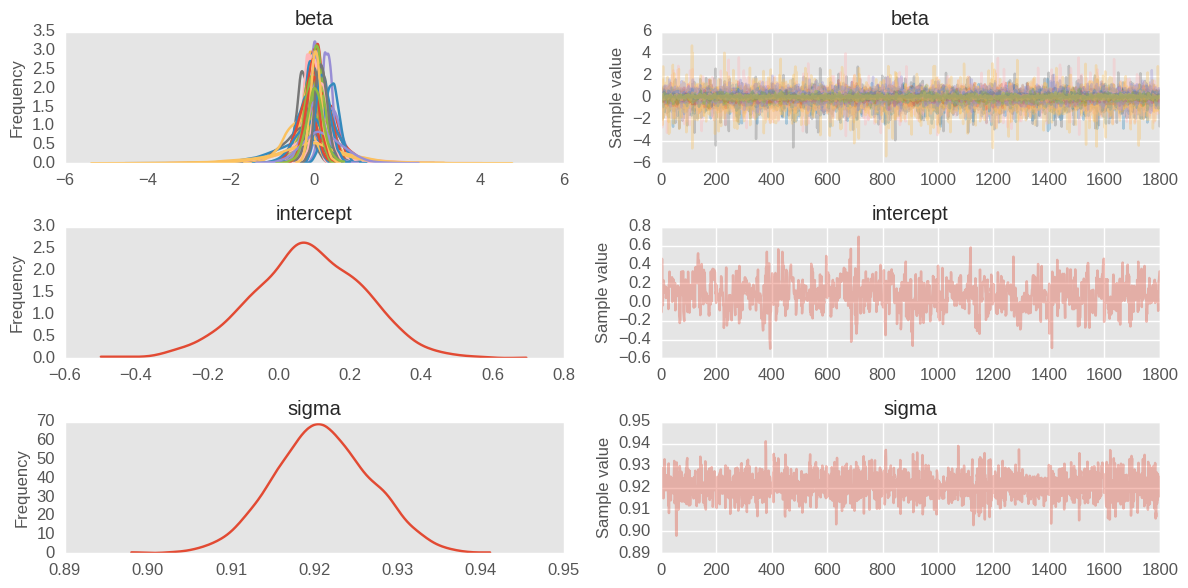

In [77]:
_ = pm.traceplot(trace[200:])

In [78]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_fluid.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

age  age_over_90    gender       bmi  bmi_missing  mech_vent  \
0  0.541299     0.334490  0.060602  0.244101    -0.399729   0.333463   
1  0.742262     0.277846  0.067629  0.220822    -0.420447   0.395087   
2 -0.001265     0.108960  0.022741 -0.349376    -0.360119  -0.038721   
3 -0.160754     0.253694 -0.220534  0.258290     0.047891   0.222415   
4 -0.265526     0.382686 -0.097978  0.293414    -0.007938   0.158164   

        CHF      mdrd  creatinine_missing    apsiii    ...      lv_severe_bmi  \
0 -0.194756 -0.013749            0.075683  0.266994    ...           0.392666   
1  0.044213 -0.023727           -0.136550  0.165094    ...           0.583194   
2 -0.185451  0.113021           -0.171398  0.424713    ...          -0.784307   
3 -0.256121 -0.193153            0.260931  0.119333    ...           0.605199   
4 -0.138013 -0.273011           -0.025782  0.131469    ...           1.292774   

   lv_severe_bmi_missing  lv_severe_mech_vent  lv_severe_CHF  lv_severe_mdrd  \
0               0.219059            -0.092892      -0.142139        0.124986   
1               0.055884            -0.123964      -0.181938        0.157651   
2               0.192892             0.247991       0.088128       -0.146511   
3              -0.263888            -0.010996       0.003631        0.256066   
4              -0.167689            -0.014011      -0.054255        0.408330   

   lv_severe_creatinine_missing  lv_severe_apsiii  lv_severe_lactate  \
0                      0.071022          0.184512           0.116118   
1                      0.225486          0.269235          -0.044762   
2                      0.015176         -0.054615          -0.078673   
3                     -0.029777          0.322808           0.153452   
4                     -0.192166          0.377972           0.245218   

   lv_severe_lactate_missing  intercept  
0                  -0.080463   0.140977  
1                   0.034681   0.239779  
2                   0.188979  -0.113844  
3                   0.035673  -0.094314  
4                   0.059755  -0.045606  

[5 rows x 91 columns]

In [79]:
sample_coefs.describe()

age  age_over_90       gender          bmi  bmi_missing  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean      0.301307     0.246513    -0.042433    -0.057050    -0.109302   
std       0.243096     0.212917     0.147028     0.272376     0.139854   
min      -0.603959    -0.451027    -0.609390    -1.269559    -0.626705   
25%       0.140820     0.106308    -0.134346    -0.169277    -0.201017   
50%       0.311283     0.247173    -0.033097    -0.036487    -0.107735   
75%       0.473474     0.382460     0.057248     0.082851    -0.017145   
max       1.290878     1.190593     0.411226     1.004566     0.381387   

         mech_vent          CHF         mdrd  creatinine_missing       apsiii  \
count  1800.000000  1800.000000  1800.000000         1800.000000  1800.000000   
mean      0.067424    -0.132167    -0.077816           -0.083638     0.300023   
std       0.151214     0.145237     0.144815            0.266775     0.133127   
min      -0.457474    -0.757873    -0.663132           -1.142333    -0.159493   
25%      -0.018971    -0.220283    -0.161856           -0.233445     0.222204   
50%       0.065998    -0.135285    -0.056866           -0.068151     0.303547   
75%       0.154911    -0.037429     0.022548            0.073229     0.388542   
max       0.615814     0.405150     0.364308            0.882240     0.814576   

          ...       lv_severe_bmi  lv_severe_bmi_missing  lv_severe_mech_vent  \
count     ...         1800.000000            1800.000000          1800.000000   
mean      ...           -0.289163              -0.064312             0.170763   
std       ...            0.984230               0.172712             0.181061   
min       ...           -5.359879              -0.763327            -0.525182   
25%       ...           -0.719416              -0.179384             0.046195   
50%       ...           -0.179312              -0.062539             0.165565   
75%       ...            0.249537               0.044662             0.290442   
max       ...            3.122858               0.677466             0.815470   

       lv_severe_CHF  lv_severe_mdrd  lv_severe_creatinine_missing  \
count    1800.000000     1800.000000                   1800.000000   
mean       -0.039964        0.227916                      0.200665   
std         0.185197        0.168641                      0.497156   
min        -0.746499       -0.240655                     -1.389593   
25%        -0.159162        0.109897                     -0.134049   
50%        -0.033953        0.212332                      0.167704   
75%         0.074028        0.330824                      0.511647   
max         0.660897        0.861905                      2.509057   

       lv_severe_apsiii  lv_severe_lactate  lv_severe_lactate_missing  \
count       1800.000000        1800.000000                1800.000000   
mean           0.169115           0.046198                   0.016658   
std            0.148838           0.142115                   0.213667   
min           -0.330161          -0.429829                  -0.910636   
25%            0.064975          -0.044853                  -0.114086   
50%            0.163821           0.038393                   0.015225   
75%            0.267578           0.128743                   0.148277   
max            0.684252           0.618933                   0.716459   

         intercept  
count  1800.000000  
mean      0.082174  
std       0.158303  
min      -0.498513  
25%      -0.019921  
50%       0.082308  
75%       0.190768  
max       0.694685  

[8 rows x 91 columns]

In [80]:
W = sample_coefs.values[:,:X_fluid.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_fluid.values, W.T) + b
y_ppc = y_ppc.T

In [81]:
r2_ppc = np.zeros(len(y_ppc))
for i in range(len(y_ppc)):
    yh = y_ppc[i]
    r = pearsonr(yh, y_fluid)[0]
    r2_ppc[i] = r**2

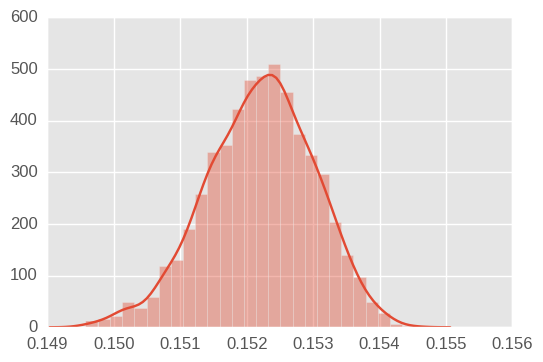

In [82]:
sns.distplot(r2_ppc)

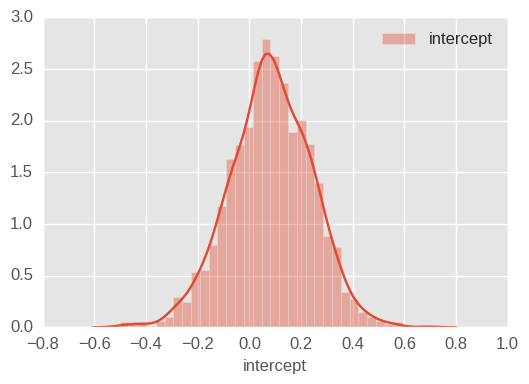

In [83]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

age  age_over_90       gender          bmi  bmi_missing
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000
mean      0.301307     0.246513    -0.042433    -0.057050    -0.109302
std       0.243096     0.212917     0.147028     0.272376     0.139854
min      -0.603959    -0.451027    -0.609390    -1.269559    -0.626705
25%       0.140820     0.106308    -0.134346    -0.169277    -0.201017
50%       0.311283     0.247173    -0.033097    -0.036487    -0.107735
75%       0.473474     0.382460     0.057248     0.082851    -0.017145
max       1.290878     1.190593     0.411226     1.004566     0.381387

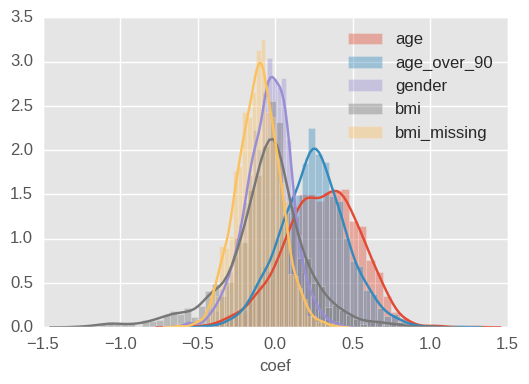

In [84]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

mech_vent          CHF       apsiii         mdrd  creatinine_missing  \
count  1800.000000  1800.000000  1800.000000  1800.000000         1800.000000   
mean      0.067424    -0.132167     0.300023    -0.077816           -0.083638   
std       0.151214     0.145237     0.133127     0.144815            0.266775   
min      -0.457474    -0.757873    -0.159493    -0.663132           -1.142333   
25%      -0.018971    -0.220283     0.222204    -0.161856           -0.233445   
50%       0.065998    -0.135285     0.303547    -0.056866           -0.068151   
75%       0.154911    -0.037429     0.388542     0.022548            0.073229   
max       0.615814     0.405150     0.814576     0.364308            0.882240   

           lactate  lactate_missing  
count  1800.000000      1800.000000  
mean      0.003642        -0.256706  
std       0.130061         0.179930  
min      -0.479596        -0.910642  
25%      -0.069560        -0.364137  
50%       0.009904        -0.264473  
75%       0.089904        -0.152989  
max       0.370248         0.449042

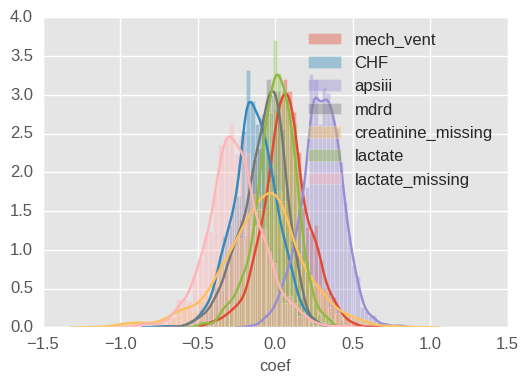

In [85]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_missing    lv_normal     lv_hyper      lv_mild  lv_moderate  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean     -0.046407     0.021882     0.207409     0.026571     0.104353   
std       0.160259     0.162704     0.206728     0.200372     0.245903   
min      -0.666081    -0.627510    -0.486631    -0.637466    -0.768944   
25%      -0.153861    -0.087973     0.062722    -0.106063    -0.049959   
50%      -0.042881     0.024712     0.202038     0.024984     0.092369   
75%       0.053111     0.122180     0.347257     0.154800     0.258960   
max       0.547611     0.629760     0.996287     0.686425     1.036215   

         lv_severe  
count  1800.000000  
mean     -0.084402  
std       0.214263  
min      -0.931867  
25%      -0.233019  
50%      -0.076353  
75%       0.052760  
max       0.654126

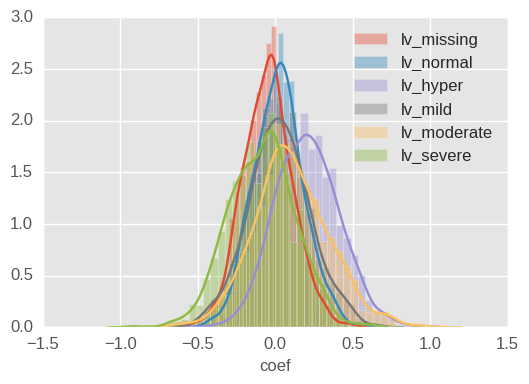

In [86]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

bmi  lv_missing_bmi  lv_normal_bmi  lv_hyper_bmi  lv_mild_bmi  \
count  1800.000000     1800.000000    1800.000000   1800.000000  1800.000000   
mean     -0.057050        0.018263       0.000821     -0.148003     0.058925   
std       0.272376        0.272036       0.282462      0.866401     0.272774   
min      -1.269559       -1.051797      -1.053420     -4.552908    -1.020729   
25%      -0.169277       -0.121948      -0.151538     -0.596876    -0.081694   
50%      -0.036487       -0.003350      -0.013064     -0.094041     0.036176   
75%       0.082851        0.130788       0.132405      0.355046     0.173429   
max       1.004566        1.225369       1.246994      2.885672     1.283920   

       lv_moderate_bmi  lv_severe_bmi  
count      1800.000000    1800.000000  
mean         -0.026418      -0.289163  
std           0.932161       0.984230  
min          -3.505955      -5.359879  
25%          -0.512998      -0.719416  
50%          -0.011744      -0.179312  
75%           0.459022       0.249537  
max           4.031639       3.122858

bmi_missing  lv_missing_bmi_missing  lv_normal_bmi_missing  \
count  1800.000000             1800.000000            1800.000000   
mean     -0.109302               -0.029639              -0.134526   
std       0.139854                0.141056               0.143091   
min      -0.626705               -0.526174              -0.614008   
25%      -0.201017               -0.125435              -0.228558   
50%      -0.107735               -0.031798              -0.134012   
75%      -0.017145                0.060238              -0.040564   
max       0.381387                0.524298               0.406230   

       lv_hyper_bmi_missing  lv_mild_bmi_missing  lv_moderate_bmi_missing  \
count           1800.000000          1800.000000              1800.000000   
mean               0.035394            -0.018604                 0.230370   
std                0.163085             0.169232                 0.199466   
min               -0.563023            -0.683828                -0.327819   
25%               -0.065743            -0.129496                 0.090019   
50%                0.033003            -0.015635                 0.223137   
75%                0.141162             0.096931                 0.364779   
max                0.605211             0.505948                 1.071036   

       lv_severe_bmi_missing  
count            1800.000000  
mean               -0.064312  
std                 0.172712  
min                -0.763327  
25%                -0.179384  
50%                -0.062539  
75%                 0.044662  
max                 0.677466

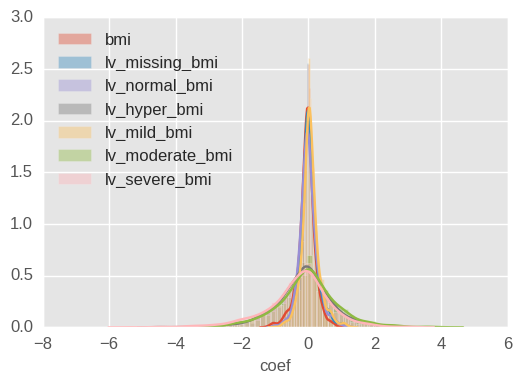

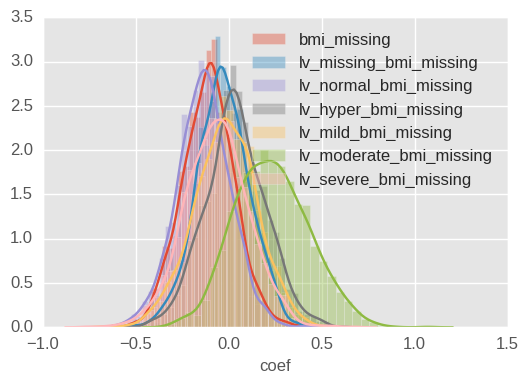

In [87]:
suffix = 'bmi'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

suffix = 'bmi_missing'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

age  lv_missing_age  lv_normal_age  lv_hyper_age  lv_mild_age  \
count  1800.000000     1800.000000    1800.000000   1800.000000  1800.000000   
mean      0.301307        0.207667       0.370858      0.305783    -0.055812   
std       0.243096        0.247837       0.259704      0.359177     0.330810   
min      -0.603959       -0.717176      -0.561139     -1.066529    -1.275750   
25%       0.140820        0.030119       0.181134      0.050517    -0.260277   
50%       0.311283        0.198013       0.369014      0.289344    -0.052771   
75%       0.473474        0.372758       0.537970      0.530875     0.151527   
max       1.290878        1.154268       1.252984      1.639120     1.145136   

       lv_moderate_age  lv_severe_age  
count      1800.000000    1800.000000  
mean         -0.325458      -0.111397  
std           0.403384       0.354551  
min          -2.032362      -1.479212  
25%          -0.583358      -0.353669  
50%          -0.296693      -0.088435  
75%          -0.037488       0.116927  
max           1.069310       1.251576

age_over_90  lv_missing_age_over_90  lv_normal_age_over_90  \
count  1800.000000             1800.000000            1800.000000   
mean      0.246513                0.030991               0.083412   
std       0.212917                0.215622               0.221108   
min      -0.451027               -0.911706              -0.775085   
25%       0.106308               -0.103186              -0.048437   
50%       0.247173                0.026333               0.076515   
75%       0.382460                0.174269               0.222713   
max       1.190593                0.705633               0.774248   

       lv_hyper_age_over_90  lv_mild_age_over_90  lv_moderate_age_over_90  \
count           1800.000000          1800.000000              1800.000000   
mean               0.297075             0.045835                -0.403710   
std                0.281074             0.266687                 0.338374   
min               -0.682662            -1.148705                -1.689519   
25%                0.099935            -0.123866                -0.625395   
50%                0.292011             0.036954                -0.390118   
75%                0.476082             0.216531                -0.164650   
max                1.237412             0.976765                 0.651601   

       lv_severe_age_over_90  
count            1800.000000  
mean                0.048310  
std                 0.270706  
min                -0.908416  
25%                -0.119213  
50%                 0.034707  
75%                 0.216355  
max                 1.050885

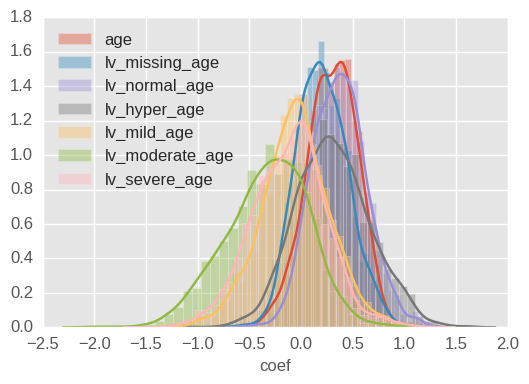

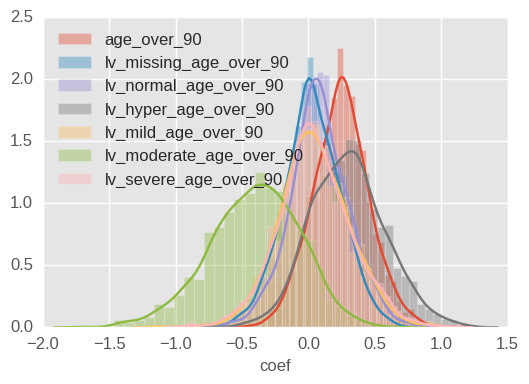

In [88]:
suffix = 'age'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

suffix = 'age_over_90'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

gender  lv_missing_gender  lv_normal_gender  lv_hyper_gender  \
count  1800.000000        1800.000000       1800.000000      1800.000000   
mean     -0.042433           0.091342          0.094381         0.025689   
std       0.147028           0.148543          0.150072         0.169403   
min      -0.609390          -0.363793         -0.415227        -0.543553   
25%      -0.134346          -0.008223         -0.006146        -0.087582   
50%      -0.033097           0.081234          0.083200         0.020751   
75%       0.057248           0.185276          0.189705         0.134450   
max       0.411226           0.649994          0.657381         0.671513   

       lv_mild_gender  lv_moderate_gender  lv_severe_gender  
count     1800.000000         1800.000000       1800.000000  
mean        -0.028811            0.228121          0.023644  
std          0.171617            0.201008          0.176001  
min         -0.656888           -0.401089         -0.551478  
25%         -0.144450            0.084360         -0.084976  
50%         -0.028966            0.219629          0.013911  
75%          0.071674            0.355555          0.130285  
max          0.680278            1.028484          0.774295

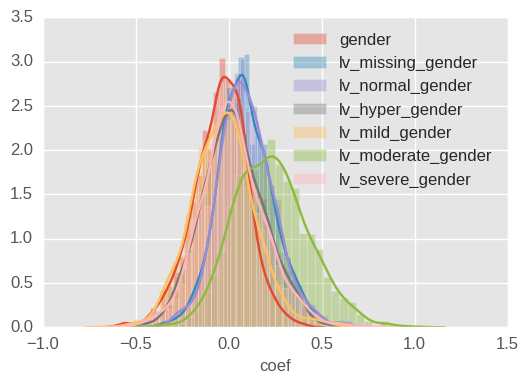

In [89]:
suffix = 'gender'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

apsiii  lv_missing_apsiii  lv_normal_apsiii  lv_hyper_apsiii  \
count  1800.000000        1800.000000       1800.000000      1800.000000   
mean      0.300023          -0.030190          0.016485         0.016438   
std       0.133127           0.133467          0.135144         0.143936   
min      -0.159493          -0.556001         -0.526960        -0.535534   
25%       0.222204          -0.121302         -0.074442        -0.074981   
50%       0.303547          -0.032786          0.014465         0.013538   
75%       0.388542           0.050121          0.098763         0.107710   
max       0.814576           0.447797          0.518476         0.564944   

       lv_mild_apsiii  lv_moderate_apsiii  lv_severe_apsiii  
count     1800.000000         1800.000000       1800.000000  
mean        -0.057955            0.129051          0.169115  
std          0.149264            0.157129          0.148838  
min         -0.645737           -0.459526         -0.330161  
25%         -0.157519            0.025372          0.064975  
50%         -0.054723            0.127499          0.163821  
75%          0.030996            0.227168          0.267578  
max          0.422571            0.699301          0.684252

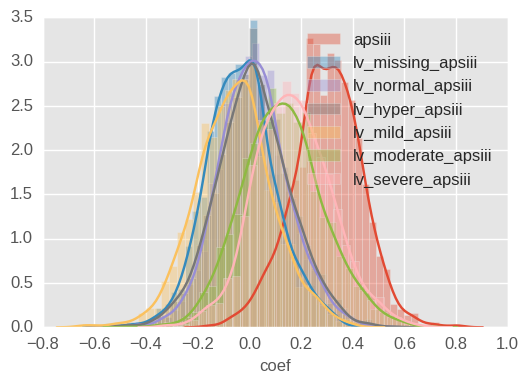

In [90]:
suffix = 'apsiii'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

CHF  lv_missing_CHF  lv_normal_CHF  lv_hyper_CHF  lv_mild_CHF  \
count  1800.000000     1800.000000    1800.000000   1800.000000  1800.000000   
mean     -0.132167       -0.050847      -0.098174     -0.079423     0.131791   
std       0.145237        0.146306       0.149823      0.180216     0.175101   
min      -0.757873       -0.592832      -0.696366     -0.677998    -0.591561   
25%      -0.220283       -0.146901      -0.193999     -0.199143     0.018040   
50%      -0.135285       -0.049188      -0.097375     -0.075477     0.129006   
75%      -0.037429        0.040606      -0.001483      0.039600     0.245315   
max       0.405150        0.554702       0.560369      0.698496     0.798394   

       lv_moderate_CHF  lv_severe_CHF  
count      1800.000000    1800.000000  
mean          0.031441      -0.039964  
std           0.194767       0.185197  
min          -0.648721      -0.746499  
25%          -0.098481      -0.159162  
50%           0.031277      -0.033953  
75%           0.160193       0.074028  
max           0.747681       0.660897

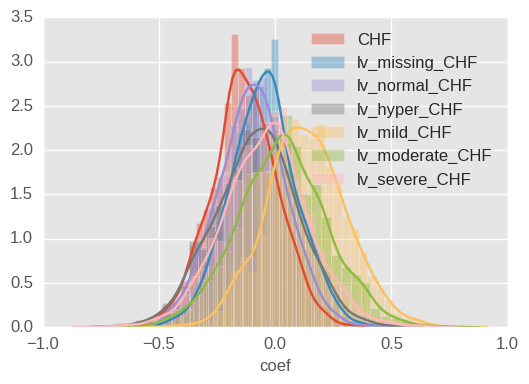

In [91]:
suffix = 'CHF'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

mech_vent  lv_missing_mech_vent  lv_normal_mech_vent  \
count  1800.000000           1800.000000          1800.000000   
mean      0.067424              0.000188             0.004838   
std       0.151214              0.152767             0.152712   
min      -0.457474             -0.568298            -0.538103   
25%      -0.018971             -0.088499            -0.083786   
50%       0.065998              0.000177             0.004822   
75%       0.154911              0.087945             0.089748   
max       0.615814              0.565834             0.519616   

       lv_hyper_mech_vent  lv_mild_mech_vent  lv_moderate_mech_vent  \
count         1800.000000        1800.000000            1800.000000   
mean            -0.143463           0.022420              -0.214318   
std              0.181462           0.178749               0.216099   
min             -0.874257          -0.686845              -0.872887   
25%             -0.257303          -0.093343              -0.367053   
50%             -0.136461           0.024109              -0.205084   
75%             -0.026008           0.137282              -0.064573   
max              0.519861           0.748834               0.502430   

       lv_severe_mech_vent  
count          1800.000000  
mean              0.170763  
std               0.181061  
min              -0.525182  
25%               0.046195  
50%               0.165565  
75%               0.290442  
max               0.815470

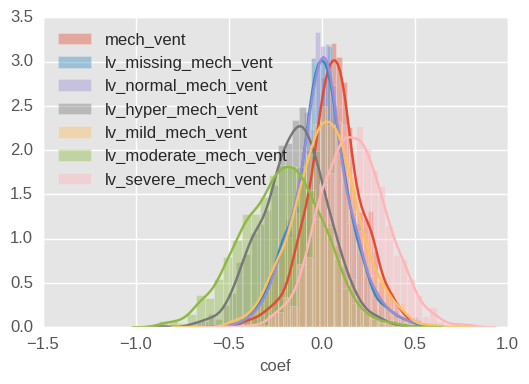

In [92]:
suffix = 'mech_vent'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

gender  lv_missing_gender  lv_normal_gender  lv_hyper_gender  \
count  1800.000000        1800.000000       1800.000000      1800.000000   
mean     -0.042433           0.091342          0.094381         0.025689   
std       0.147028           0.148543          0.150072         0.169403   
min      -0.609390          -0.363793         -0.415227        -0.543553   
25%      -0.134346          -0.008223         -0.006146        -0.087582   
50%      -0.033097           0.081234          0.083200         0.020751   
75%       0.057248           0.185276          0.189705         0.134450   
max       0.411226           0.649994          0.657381         0.671513   

       lv_mild_gender  lv_moderate_gender  lv_severe_gender  
count     1800.000000         1800.000000       1800.000000  
mean        -0.028811            0.228121          0.023644  
std          0.171617            0.201008          0.176001  
min         -0.656888           -0.401089         -0.551478  
25%         -0.144450            0.084360         -0.084976  
50%         -0.028966            0.219629          0.013911  
75%          0.071674            0.355555          0.130285  
max          0.680278            1.028484          0.774295

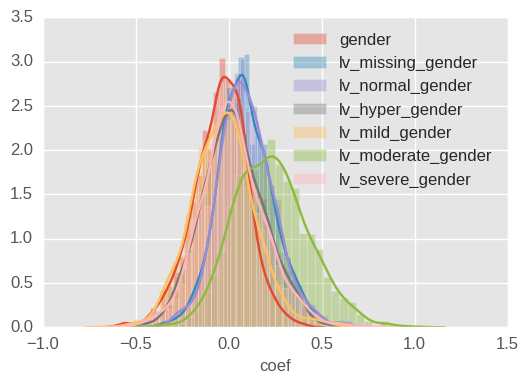

In [93]:
suffix = 'gender'
coefs = [c for c in X_fluid.columns if c.endswith(suffix)]
display(sample_coefs[coefs].describe())

f = plt.figure()
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_missing_age  lv_missing_age_over_90  lv_missing_gender  \
count     1800.000000             1800.000000        1800.000000   
mean         0.207667                0.030991           0.091342   
std          0.247837                0.215622           0.148543   
min         -0.717176               -0.911706          -0.363793   
25%          0.030119               -0.103186          -0.008223   
50%          0.198013                0.026333           0.081234   
75%          0.372758                0.174269           0.185276   
max          1.154268                0.705633           0.649994   

       lv_missing_bmi  lv_missing_bmi_missing  
count     1800.000000             1800.000000  
mean         0.018263               -0.029639  
std          0.272036                0.141056  
min         -1.051797               -0.526174  
25%         -0.121948               -0.125435  
50%         -0.003350               -0.031798  
75%          0.130788                0.060238  
max          1.225369                0.524298

lv_missing_mech_vent  lv_missing_CHF  lv_missing_apsiii  \
count           1800.000000     1800.000000        1800.000000   
mean               0.000188       -0.050847          -0.030190   
std                0.152767        0.146306           0.133467   
min               -0.568298       -0.592832          -0.556001   
25%               -0.088499       -0.146901          -0.121302   
50%                0.000177       -0.049188          -0.032786   
75%                0.087945        0.040606           0.050121   
max                0.565834        0.554702           0.447797   

       lv_missing_mdrd  lv_missing_creatinine_missing  lv_missing_lactate  \
count      1800.000000                    1800.000000         1800.000000   
mean          0.085864                       0.084943            0.090027   
std           0.145570                       0.272387            0.131046   
min          -0.363513                      -0.855883           -0.290317   
25%          -0.016590                      -0.080828            0.000600   
50%           0.064019                       0.070583            0.081273   
75%           0.171266                       0.235065            0.166383   
max           0.678829                       1.093123            0.568944   

       lv_missing_lactate_missing  
count                 1800.000000  
mean                    -0.011498  
std                      0.180992  
min                     -0.710985  
25%                     -0.115723  
50%                     -0.002906  
75%                      0.098841  
max                      0.651871

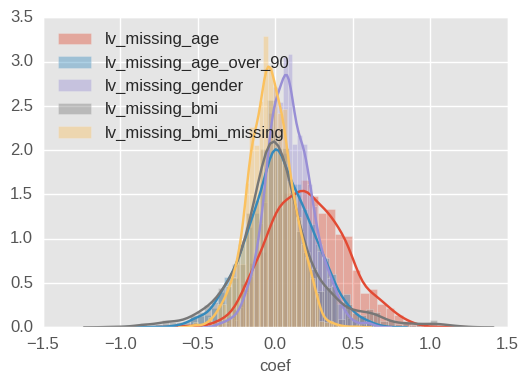

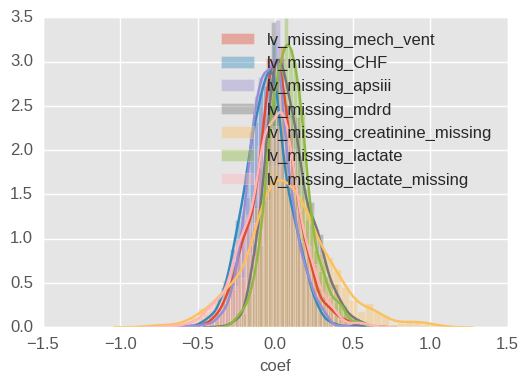

In [94]:
lv = 'lv_missing'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_normal_age  lv_normal_age_over_90  lv_normal_gender  lv_normal_bmi  \
count    1800.000000            1800.000000       1800.000000    1800.000000   
mean        0.370858               0.083412          0.094381       0.000821   
std         0.259704               0.221108          0.150072       0.282462   
min        -0.561139              -0.775085         -0.415227      -1.053420   
25%         0.181134              -0.048437         -0.006146      -0.151538   
50%         0.369014               0.076515          0.083200      -0.013064   
75%         0.537970               0.222713          0.189705       0.132405   
max         1.252984               0.774248          0.657381       1.246994   

       lv_normal_bmi_missing  
count            1800.000000  
mean               -0.134526  
std                 0.143091  
min                -0.614008  
25%                -0.228558  
50%                -0.134012  
75%                -0.040564  
max                 0.406230

lv_normal_mech_vent  lv_normal_CHF  lv_normal_apsiii  lv_normal_mdrd  \
count          1800.000000    1800.000000       1800.000000     1800.000000   
mean              0.004838      -0.098174          0.016485        0.124625   
std               0.152712       0.149823          0.135144        0.145529   
min              -0.538103      -0.696366         -0.526960       -0.292658   
25%              -0.083786      -0.193999         -0.074442        0.022507   
50%               0.004822      -0.097375          0.014465        0.108554   
75%               0.089748      -0.001483          0.098763        0.208728   
max               0.519616       0.560369          0.518476        0.734809   

       lv_normal_creatinine_missing  lv_normal_lactate  \
count                   1800.000000        1800.000000   
mean                      -0.111377           0.082341   
std                        0.289740           0.131266   
min                       -1.486148          -0.301699   
25%                       -0.295793          -0.007859   
50%                       -0.109360           0.073585   
75%                        0.057830           0.158133   
max                        1.182920           0.579912   

       lv_normal_lactate_missing  
count                1800.000000  
mean                   -0.077019  
std                     0.182619  
min                    -0.804798  
25%                    -0.184752  
50%                    -0.072960  
75%                     0.037270  
max                     0.592416

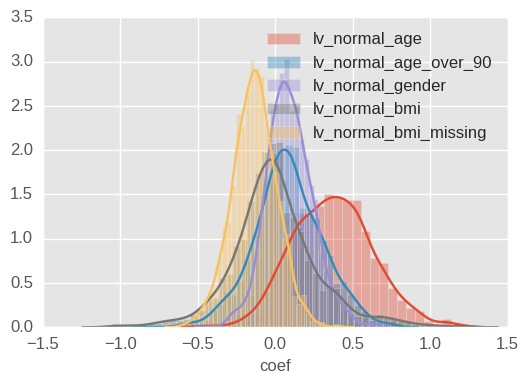

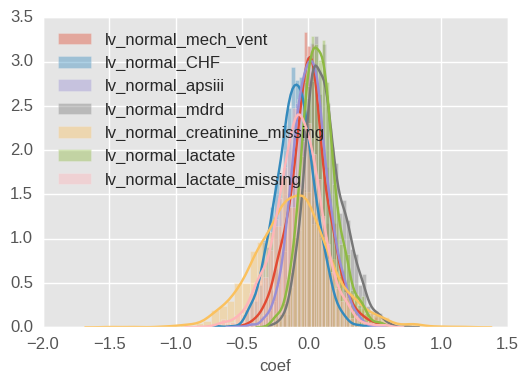

In [95]:
lv = 'lv_normal'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_hyper_age  lv_hyper_age_over_90  lv_hyper_gender  lv_hyper_bmi  \
count   1800.000000           1800.000000      1800.000000   1800.000000   
mean       0.305783              0.297075         0.025689     -0.148003   
std        0.359177              0.281074         0.169403      0.866401   
min       -1.066529             -0.682662        -0.543553     -4.552908   
25%        0.050517              0.099935        -0.087582     -0.596876   
50%        0.289344              0.292011         0.020751     -0.094041   
75%        0.530875              0.476082         0.134450      0.355046   
max        1.639120              1.237412         0.671513      2.885672   

       lv_hyper_bmi_missing  
count           1800.000000  
mean               0.035394  
std                0.163085  
min               -0.563023  
25%               -0.065743  
50%                0.033003  
75%                0.141162  
max                0.605211

lv_hyper_mech_vent  lv_hyper_CHF  lv_hyper_apsiii  lv_hyper_mdrd  \
count         1800.000000   1800.000000      1800.000000    1800.000000   
mean            -0.143463     -0.079423         0.016438       0.177650   
std              0.181462      0.180216         0.143936       0.159101   
min             -0.874257     -0.677998        -0.535534      -0.370001   
25%             -0.257303     -0.199143        -0.074981       0.064773   
50%             -0.136461     -0.075477         0.013538       0.160523   
75%             -0.026008      0.039600         0.107710       0.276456   
max              0.519861      0.698496         0.564944       0.886553   

       lv_hyper_creatinine_missing  lv_hyper_lactate  lv_hyper_lactate_missing  
count                  1800.000000       1800.000000               1800.000000  
mean                     -0.390998          0.190850                 -0.156009  
std                       0.681469          0.150071                  0.202213  
min                      -3.050930         -0.267991                 -0.936012  
25%                      -0.792734          0.088865                 -0.282513  
50%                      -0.307559          0.180861                 -0.147049  
75%                       0.055427          0.285100                 -0.020149  
max                       1.713190          0.814403                  0.528329

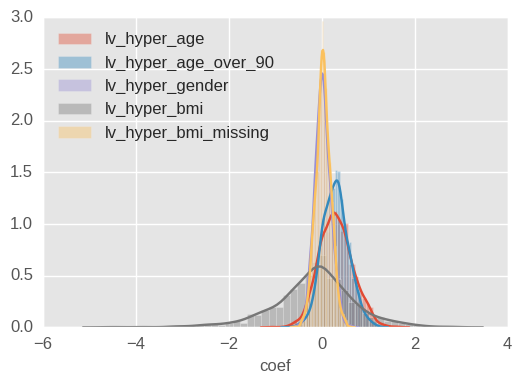

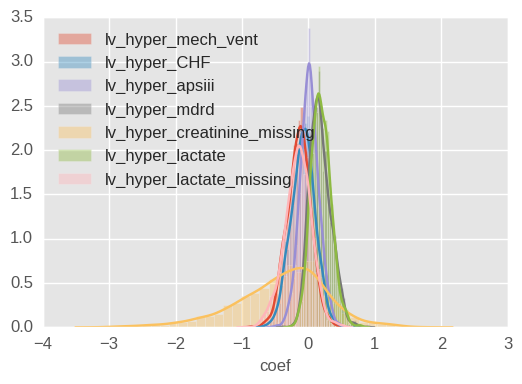

In [96]:
lv = 'lv_hyper'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_mild_age  lv_mild_age_over_90  lv_mild_gender  lv_mild_bmi  \
count  1800.000000          1800.000000     1800.000000  1800.000000   
mean     -0.055812             0.045835       -0.028811     0.058925   
std       0.330810             0.266687        0.171617     0.272774   
min      -1.275750            -1.148705       -0.656888    -1.020729   
25%      -0.260277            -0.123866       -0.144450    -0.081694   
50%      -0.052771             0.036954       -0.028966     0.036176   
75%       0.151527             0.216531        0.071674     0.173429   
max       1.145136             0.976765        0.680278     1.283920   

       lv_mild_bmi_missing  
count          1800.000000  
mean             -0.018604  
std               0.169232  
min              -0.683828  
25%              -0.129496  
50%              -0.015635  
75%               0.096931  
max               0.505948

lv_mild_mech_vent  lv_mild_CHF  lv_mild_apsiii  lv_mild_mdrd  \
count        1800.000000  1800.000000     1800.000000   1800.000000   
mean            0.022420     0.131791       -0.057955      0.153992   
std             0.178749     0.175101        0.149264      0.159234   
min            -0.686845    -0.591561       -0.645737     -0.281634   
25%            -0.093343     0.018040       -0.157519      0.038754   
50%             0.024109     0.129006       -0.054723      0.137326   
75%             0.137282     0.245315        0.030996      0.249850   
max             0.748834     0.798394        0.422571      0.715837   

       lv_mild_creatinine_missing  lv_mild_lactate  lv_mild_lactate_missing  
count                 1800.000000      1800.000000              1800.000000  
mean                    -0.135932         0.423425                -0.058837  
std                      0.579251         0.185365                 0.204856  
min                     -2.859971        -0.260843                -0.979288  
25%                     -0.463811         0.300948                -0.187411  
50%                     -0.092986         0.421846                -0.054097  
75%                      0.224958         0.543651                 0.073602  
max                      2.261035         1.111262                 0.809395

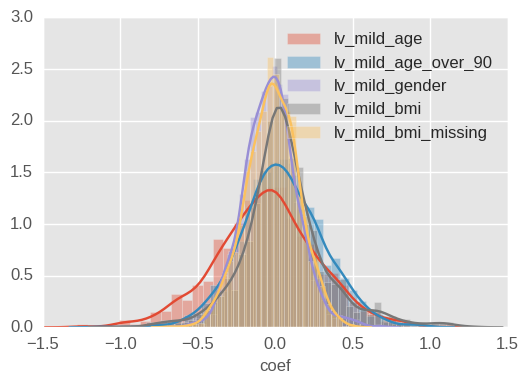

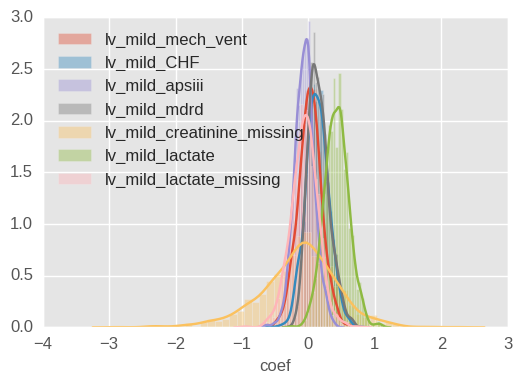

In [97]:
lv = 'lv_mild'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_moderate_age  lv_moderate_age_over_90  lv_moderate_gender  \
count      1800.000000              1800.000000         1800.000000   
mean         -0.325458                -0.403710            0.228121   
std           0.403384                 0.338374            0.201008   
min          -2.032362                -1.689519           -0.401089   
25%          -0.583358                -0.625395            0.084360   
50%          -0.296693                -0.390118            0.219629   
75%          -0.037488                -0.164650            0.355555   
max           1.069310                 0.651601            1.028484   

       lv_moderate_bmi  lv_moderate_bmi_missing  
count      1800.000000              1800.000000  
mean         -0.026418                 0.230370  
std           0.932161                 0.199466  
min          -3.505955                -0.327819  
25%          -0.512998                 0.090019  
50%          -0.011744                 0.223137  
75%           0.459022                 0.364779  
max           4.031639                 1.071036

lv_moderate_mech_vent  lv_moderate_CHF  lv_moderate_apsiii  \
count            1800.000000      1800.000000         1800.000000   
mean               -0.214318         0.031441            0.129051   
std                 0.216099         0.194767            0.157129   
min                -0.872887        -0.648721           -0.459526   
25%                -0.367053        -0.098481            0.025372   
50%                -0.205084         0.031277            0.127499   
75%                -0.064573         0.160193            0.227168   
max                 0.502430         0.747681            0.699301   

       lv_moderate_mdrd  lv_moderate_creatinine_missing  lv_moderate_lactate  \
count       1800.000000                     1800.000000          1800.000000   
mean           0.198105                       -0.005745             0.020635   
std            0.177280                        0.915436             0.148795   
min           -0.420925                       -4.646977            -0.469115   
25%            0.076074                       -0.503382            -0.078866   
50%            0.183965                       -0.007831             0.013189   
75%            0.304271                        0.469024             0.115169   
max            0.788023                        4.756192             0.569928   

       lv_moderate_lactate_missing  
count                  1800.000000  
mean                     -0.207861  
std                       0.235957  
min                      -1.094185  
25%                      -0.353992  
50%                      -0.195341  
75%                      -0.045987  
max                       0.779768

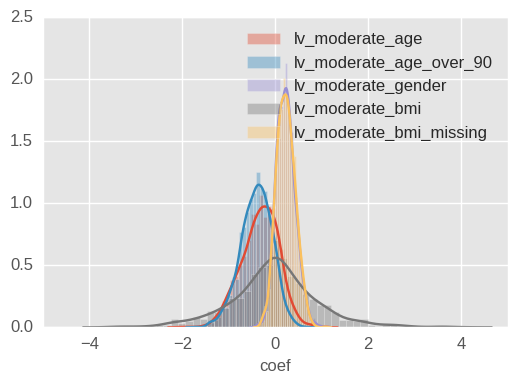

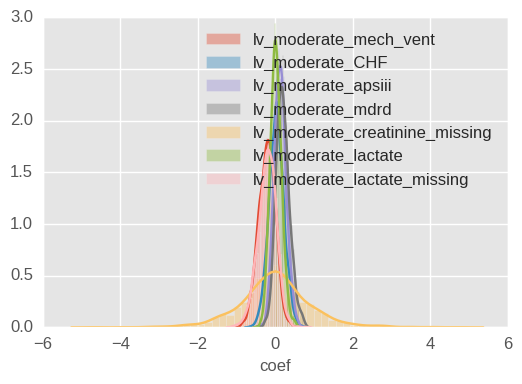

In [98]:
lv = 'lv_moderate'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_severe_age  lv_severe_age_over_90  lv_severe_gender  lv_severe_bmi  \
count    1800.000000            1800.000000       1800.000000    1800.000000   
mean       -0.111397               0.048310          0.023644      -0.289163   
std         0.354551               0.270706          0.176001       0.984230   
min        -1.479212              -0.908416         -0.551478      -5.359879   
25%        -0.353669              -0.119213         -0.084976      -0.719416   
50%        -0.088435               0.034707          0.013911      -0.179312   
75%         0.116927               0.216355          0.130285       0.249537   
max         1.251576               1.050885          0.774295       3.122858   

       lv_severe_bmi_missing  
count            1800.000000  
mean               -0.064312  
std                 0.172712  
min                -0.763327  
25%                -0.179384  
50%                -0.062539  
75%                 0.044662  
max                 0.677466

lv_severe_mech_vent  lv_severe_CHF  lv_severe_apsiii  lv_severe_mdrd  \
count          1800.000000    1800.000000       1800.000000     1800.000000   
mean              0.170763      -0.039964          0.169115        0.227916   
std               0.181061       0.185197          0.148838        0.168641   
min              -0.525182      -0.746499         -0.330161       -0.240655   
25%               0.046195      -0.159162          0.064975        0.109897   
50%               0.165565      -0.033953          0.163821        0.212332   
75%               0.290442       0.074028          0.267578        0.330824   
max               0.815470       0.660897          0.684252        0.861905   

       lv_severe_creatinine_missing  lv_severe_lactate  \
count                   1800.000000        1800.000000   
mean                       0.200665           0.046198   
std                        0.497156           0.142115   
min                       -1.389593          -0.429829   
25%                       -0.134049          -0.044853   
50%                        0.167704           0.038393   
75%                        0.511647           0.128743   
max                        2.509057           0.618933   

       lv_severe_lactate_missing  
count                1800.000000  
mean                    0.016658  
std                     0.213667  
min                    -0.910636  
25%                    -0.114086  
50%                     0.015225  
75%                     0.148277  
max                     0.716459

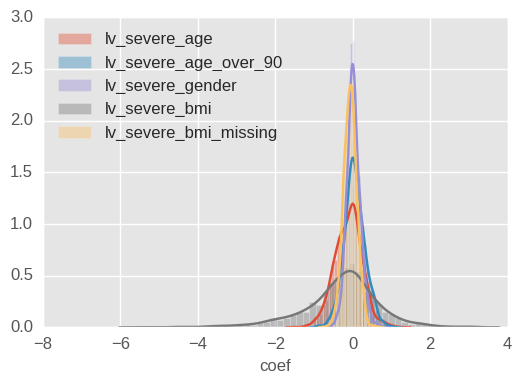

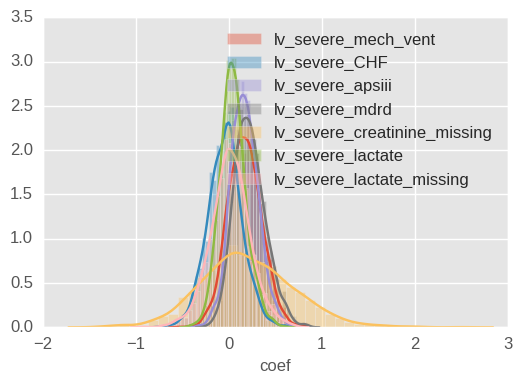

In [99]:
lv = 'lv_severe'

f = plt.figure()
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

f = plt.figure()
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
coefs = [lv + '_' + c for c in coefs]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

## Simple linear model for predicting 30-day mortality

In [180]:
## make the features table. include fluid balance on days 1,2,3 of ICU stay
X_mortality = X.copy()

def bound(fl):
    return (fl < -8000) | (fl > 8000)

fluid_day1 = ef.fb_day1_balance_ml.values
fl_missing = np.isnan(fluid_day1) | bound(fluid_day1) # also filter insane fluid balances
fluid_day1[~fl_missing] = normalize(fluid_day1[~fl_missing])
fluid_day1[fl_missing] = 0
X_mortality['fluid_day1'] = fluid_day1
X_mortality['fluid_day1_missing'] = fl_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
fl_missing = np.isnan(fluid_day2) | bound(fluid_day2)
fluid_day2[~fl_missing] = normalize(fluid_day2[~fl_missing])
fluid_day2[fl_missing] = 0
X_mortality['fluid_day2'] = fluid_day2
X_mortality['fluid_day2_missing'] = fl_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
fl_missing = np.isnan(fluid_day3) | bound(fluid_day3)
fluid_day3[~fl_missing] = normalize(fluid_day3[~fl_missing])
fluid_day3[fl_missing] = 0
X_mortality['fluid_day3'] = fluid_day3
X_mortality['fluid_day3_missing'] = fl_missing.astype(float)

In [181]:
y_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')
y_mortality = y_mortality.astype(float)
y_mortality.mean(), y_mortality.sum(), len(y_mortality)

(0.26422673510377148, 3552.0, 13443)

In [182]:
with pm.Model() as model:
    #pm.glm.glm('y ~ x', data)
    logistic(X_mortality, y_mortality)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 6570.382672
         Iterations: 33
         Function evaluations: 43
         Gradient evaluations: 43


100%|██████████| 2000/2000 [04:30<00:00,  7.40it/s]


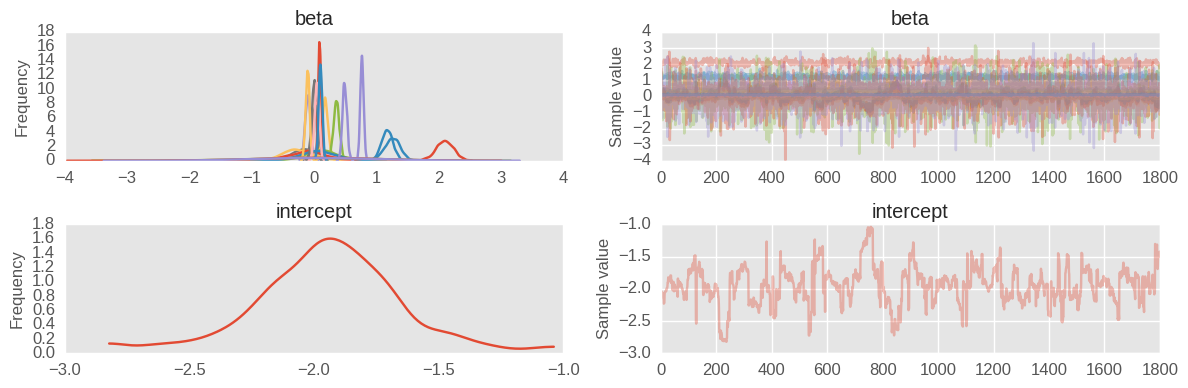

In [183]:
_ = pm.traceplot(trace[200:])

In [184]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_mortality.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

age  age_over_90    gender       bmi  bmi_missing  mech_vent  \
0  1.991041     1.091386 -0.106574  0.012822     0.156888   0.289490   
1  1.907724     1.147652 -0.131328 -0.036124     0.150450   0.366917   
2  1.907724     1.147652 -0.131328 -0.036124     0.150450   0.366917   
3  1.908551     1.098978 -0.112411  0.054390     0.148785   0.395049   
4  1.912903     1.092121 -0.112247  0.085384     0.166839   0.359478   

        CHF      mdrd  creatinine_missing    apsiii    ...      lv_severe  \
0  0.069326  0.109886            0.960646  0.724114    ...       0.379486   
1 -0.030883  0.063433            1.459458  0.798367    ...       0.319689   
2 -0.030883  0.063433            1.459458  0.798367    ...       0.319689   
3 -0.055790  0.054850            1.346011  0.753002    ...       0.467590   
4 -0.008219  0.064040            1.162952  0.765498    ...       0.401050   

    lactate  lactate_missing  fluid_day1  fluid_day1_missing  fluid_day2  \
0  0.484404         0.015256   -0.104421            1.667380    0.029340   
1  0.476477        -0.009258   -0.090154           -1.019334   -0.007722   
2  0.476477        -0.009258   -0.090154           -1.019334   -0.007722   
3  0.524237         0.092801   -0.117839            1.471575    0.060716   
4  0.486658         0.013794   -0.137984            1.517184    0.061287   

   fluid_day2_missing  fluid_day3  fluid_day3_missing  intercept  
0           -1.006167    0.114691            1.830729  -2.156435  
1            1.755482    0.117689           -0.715883  -2.094433  
2            1.755482    0.117689           -0.715883  -2.094433  
3           -0.679058    0.113809            0.004145  -2.042062  
4            0.317306    0.079129           -1.332216  -2.058362  

[5 rows x 25 columns]

In [185]:
sample_coefs.describe()

age  age_over_90       gender          bmi  bmi_missing  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean      2.095919     1.172399    -0.098504    -0.003373     0.181766   
std       0.141125     0.090209     0.042907     0.037484     0.047087   
min       1.597046     0.891257    -0.235091    -0.170313     0.044336   
25%       1.998262     1.111927    -0.127512    -0.026051     0.150435   
50%       2.096780     1.172577    -0.098158    -0.000464     0.179536   
75%       2.192565     1.233650    -0.070959     0.020208     0.211672   
max       2.530164     1.445993     0.063620     0.126396     0.353078   

         mech_vent          CHF         mdrd  creatinine_missing       apsiii  \
count  1800.000000  1800.000000  1800.000000         1800.000000  1800.000000   
mean      0.358893     0.033022     0.089512            1.253417     0.768031   
std       0.047477     0.049130     0.023061            0.124067     0.026956   
min       0.193365    -0.136274     0.015529            0.862161     0.671680   
25%       0.327295    -0.001386     0.073820            1.173470     0.749839   
50%       0.358456     0.033162     0.089286            1.255562     0.767733   
75%       0.388451     0.066500     0.104849            1.338679     0.786100   
max       0.510147     0.188337     0.165523            1.707952     0.863375   

          ...         lv_severe      lactate  lactate_missing   fluid_day1  \
count     ...       1800.000000  1800.000000      1800.000000  1800.000000   
mean      ...          0.068414     0.492581         0.024070    -0.103159   
std       ...          0.315212     0.036184         0.049477     0.031225   
min       ...         -1.008821     0.365797        -0.127885    -0.208452   
25%       ...         -0.132126     0.468687        -0.010035    -0.123366   
50%       ...          0.062297     0.491717         0.023152    -0.102935   
75%       ...          0.263024     0.517411         0.057565    -0.082715   
max       ...          1.154913     0.627412         0.212514     0.038849   

       fluid_day1_missing   fluid_day2  fluid_day2_missing   fluid_day3  \
count         1800.000000  1800.000000         1800.000000  1800.000000   
mean            -0.032732     0.045812           -0.000734     0.103212   
std              1.023116     0.036157            0.949582     0.029017   
min             -3.563429    -0.083416           -3.965271     0.021235   
25%             -0.723390     0.021942           -0.619057     0.083398   
50%             -0.038551     0.045845            0.007992     0.102646   
75%              0.667017     0.069616            0.635384     0.122850   
max              3.154141     0.157708            3.004049     0.209484   

       fluid_day3_missing    intercept  
count         1800.000000  1800.000000  
mean             0.006152    -1.944325  
std              0.967143     0.291929  
min             -3.372523    -2.821553  
25%             -0.638715    -2.118546  
50%             -0.001078    -1.938192  
75%              0.664606    -1.771412  
max              3.298793    -1.038819  

[8 rows x 25 columns]

In [190]:
W = sample_coefs.values[:,:X_mortality.shape[1]]
b = sample_coefs['intercept'].values

y_ppc = np.dot(X_mortality.values, W.T) + b
y_ppc = y_ppc.T
y_ppc.shape, y_mortality.shape

((1800, 13443), (13443,))

In [197]:
acc_ppc = (y_ppc > 0).astype(float) == y_mortality.values
acc_ppc = acc_ppc.mean(axis=1)

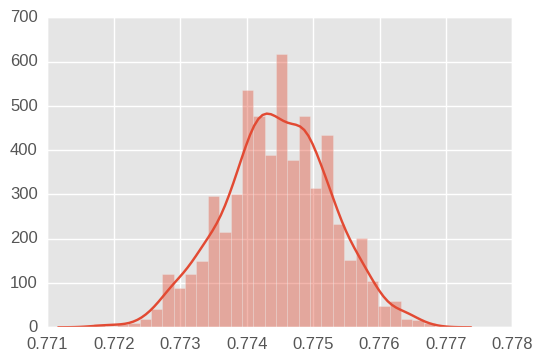

In [198]:
sns.distplot(acc_ppc)

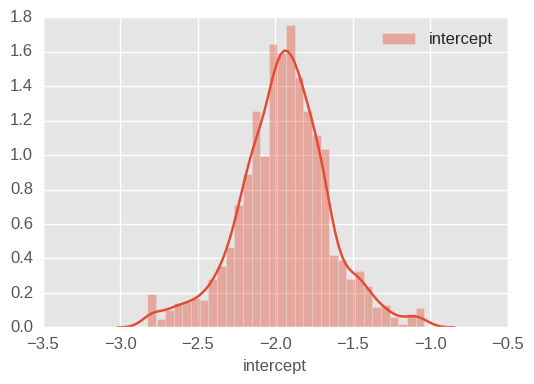

In [199]:
coefs = ['intercept']
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
_ = plt.legend(loc='best')

age  age_over_90       gender          bmi  bmi_missing
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000
mean      2.095919     1.172399    -0.098504    -0.003373     0.181766
std       0.141125     0.090209     0.042907     0.037484     0.047087
min       1.597046     0.891257    -0.235091    -0.170313     0.044336
25%       1.998262     1.111927    -0.127512    -0.026051     0.150435
50%       2.096780     1.172577    -0.098158    -0.000464     0.179536
75%       2.192565     1.233650    -0.070959     0.020208     0.211672
max       2.530164     1.445993     0.063620     0.126396     0.353078

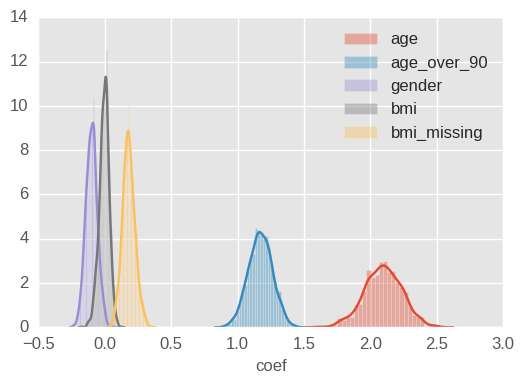

In [200]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

mech_vent          CHF       apsiii         mdrd  creatinine_missing  \
count  1800.000000  1800.000000  1800.000000  1800.000000         1800.000000   
mean      0.358893     0.033022     0.768031     0.089512            1.253417   
std       0.047477     0.049130     0.026956     0.023061            0.124067   
min       0.193365    -0.136274     0.671680     0.015529            0.862161   
25%       0.327295    -0.001386     0.749839     0.073820            1.173470   
50%       0.358456     0.033162     0.767733     0.089286            1.255562   
75%       0.388451     0.066500     0.786100     0.104849            1.338679   
max       0.510147     0.188337     0.863375     0.165523            1.707952   

           lactate  lactate_missing  
count  1800.000000      1800.000000  
mean      0.492581         0.024070  
std       0.036184         0.049477  
min       0.365797        -0.127885  
25%       0.468687        -0.010035  
50%       0.491717         0.023152  
75%       0.517411         0.057565  
max       0.627412         0.212514

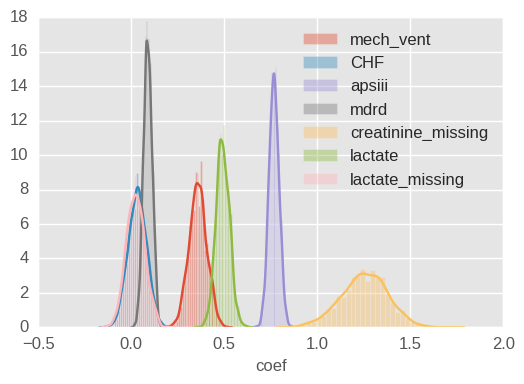

In [201]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

lv_missing    lv_normal     lv_hyper      lv_mild  lv_moderate  \
count  1800.000000  1800.000000  1800.000000  1800.000000  1800.000000   
mean     -0.111150    -0.271172     0.133993    -0.034374    -0.094200   
std       0.285533     0.290854     0.302681     0.305771     0.323145   
min      -0.985134    -1.185658    -0.784152    -0.996843    -1.214867   
25%      -0.281923    -0.446237    -0.052547    -0.227685    -0.298630   
50%      -0.125250    -0.284572     0.120959    -0.043947    -0.090983   
75%       0.048746    -0.107524     0.304359     0.149209     0.086699   
max       0.782538     0.655898     1.095599     1.051761     0.982833   

         lv_severe  
count  1800.000000  
mean      0.068414  
std       0.315212  
min      -1.008821  
25%      -0.132126  
50%       0.062297  
75%       0.263024  
max       1.154913

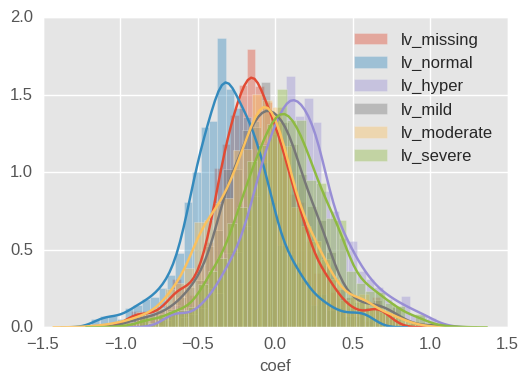

In [202]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

fluid_day1   fluid_day2   fluid_day3
count  1800.000000  1800.000000  1800.000000
mean     -0.103159     0.045812     0.103212
std       0.031225     0.036157     0.029017
min      -0.208452    -0.083416     0.021235
25%      -0.123366     0.021942     0.083398
50%      -0.102935     0.045845     0.102646
75%      -0.082715     0.069616     0.122850
max       0.038849     0.157708     0.209484

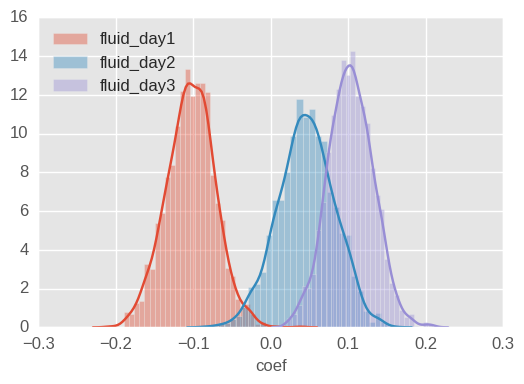

In [204]:
coefs = ['fluid_day1', 'fluid_day2', 'fluid_day3']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

fluid_day1_missing  fluid_day2_missing  fluid_day3_missing
count         1800.000000         1800.000000         1800.000000
mean            -0.032732           -0.000734            0.006152
std              1.023116            0.949582            0.967143
min             -3.563429           -3.965271           -3.372523
25%             -0.723390           -0.619057           -0.638715
50%             -0.038551            0.007992           -0.001078
75%              0.667017            0.635384            0.664606
max              3.154141            3.004049            3.298793

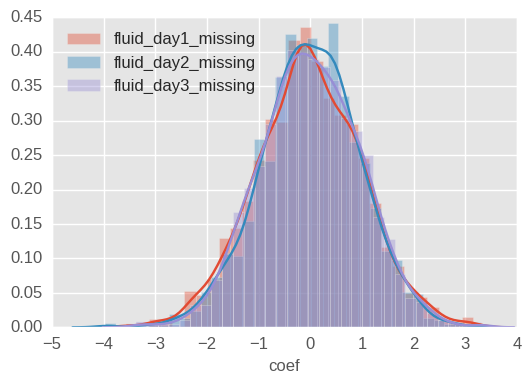

In [205]:
coefs = ['fluid_day1_missing', 'fluid_day2_missing', 'fluid_day3_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')